# 손글씨 이미지 추측 모델 개발 (MNIST Dataset 활용)

In [1]:
import matplotlib.pyplot as plt
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor         # 이미지 변형
from torch.utils.data.dataloader import DataLoader  # train - test 분리
import torch
import torch.nn as nn
from torch.optim.adam import Adam

## 데이터 불러오기

In [2]:
train_data = MNIST(root='./', train=True, download=True, transform=ToTensor())
test_data = MNIST(root='./', train=False, download=True, transform=ToTensor())

## 데이터 확인하기

In [3]:
train_data.data.size()

torch.Size([60000, 28, 28])

In [4]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [5]:
train_data.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

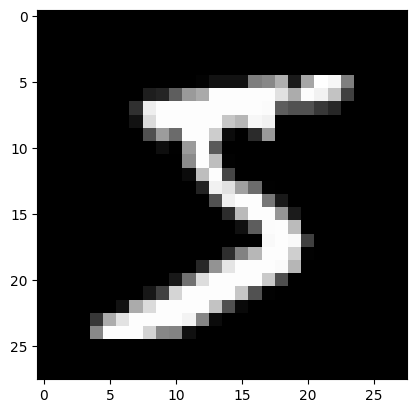

In [6]:
plt.imshow(train_data.data[0], cmap='gray')
plt.show()

## 배치 사이즈에 따른 데이터 분리

In [7]:
60000/32

1875.0

In [8]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [9]:
train_loader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()

In [10]:
data = next(iter(train_loader))[0]
data.shape # 32 배치 사이즈, 이미지 데이터는 3차원

torch.Size([32, 1, 28, 28])

## 모델 만들기

In [11]:
model = nn.Sequential(
    nn.Linear(784, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
)

## 모델 학습

In [12]:
len(next(iter(train_loader))[1]) # 정답 데이터

32

In [13]:
def draw_error_graph(error_list):
        # 그래프 시각화
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,5))
    plt.plot(error_list, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
# 데이터 gpu 에 올리기

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [15]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()

lr = 1e-3 # 0.001
criterion = nn.CrossEntropyLoss()
optim = Adam(model.parameters(), lr=lr)
epochs  = 20

model.to(device)

step = 0
for epoch in range(epochs):
    for data, label in train_loader: # [(data, label)]
        optim.zero_grad() # 최적화 함수를 초기화 해야함 (한 번 학습시 마다)

        # 모델의 입력 데이터 형식 반드시 맞출 것
        data = torch.reshape(data, (-1, 784)) 

        # 모델 학습
        pred = model(data.to(device)) # 데이터 위치 체크

        # 손실 계산
        loss = criterion(pred, label.to(device)) # 데이터 위치 체크

        # tensorboard에 데이터 추가
        writer.add_scalar("Loss/train", loss.item(), step)
        step += 1

        # 역전파
        loss.backward()
        optim.step()

    print(f"{epoch} loss : {loss.item()}")

0 loss : 0.18538418412208557
1 loss : 0.34047287702560425
2 loss : 0.0634937435388565
3 loss : 0.0937446653842926
4 loss : 0.06596513837575912
5 loss : 0.21435464918613434
6 loss : 0.0859408900141716
7 loss : 0.0047937254421412945
8 loss : 0.03915576636791229
9 loss : 0.06085558235645294
10 loss : 0.03270756080746651
11 loss : 0.00259251706302166
12 loss : 0.004767987877130508
13 loss : 9.0953049948439e-05
14 loss : 0.00468360586091876
15 loss : 0.03347509726881981
16 loss : 0.008152410387992859
17 loss : 0.0012018809793516994
18 loss : 7.295885006897151e-05
19 loss : 0.04748621582984924


In [30]:
import joblib

# 모델 저장
joblib.dump(model, 'models/number_image_classification_model.pkl')

['models/number_image_classification_model.pkl']

## 학습 결과 시각적으로 확인하기

`uv add tensorboardX`

`uv add tensorboard`
`uv run tensorboard --logdir=runs`
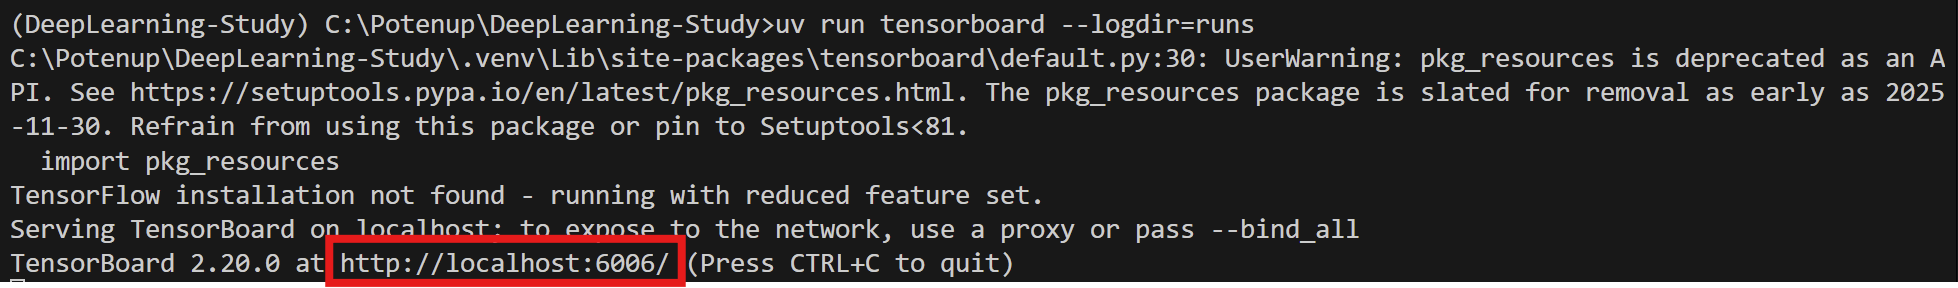

## 모델 평가 :  추론용 모델 만들기

In [16]:
test_loader.dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: ToTensor()

In [31]:
import joblib

# 모델 불러오기
loaded_model = joblib.load('models/number_image_classification_model.pkl')

In [32]:
loaded_model.eval() # 모델을 추론용으로 전환하게 하는 코드

falut_data = []

with torch.no_grad():
    total_corr = 0
    for images, labels in test_loader:
        X = images.view(-1, 784).to(device)
        labels = labels.to(device)

        preds = loaded_model(X)
        _, pred = torch.max(preds.data, dim = 1)
        
        result = (pred == labels)
        total_corr += (result).sum().item()

        for i, re in enumerate(result):
            if re == False:
                falut_data.append({
                    'image' : images[i],
                    'pred' : pred[i],
                    'label' :labels[i]
                })

print(f'정확도 : {total_corr / len(test_data.targets)}')

정확도 : 0.9722


예측 : 2, 정답 : 8


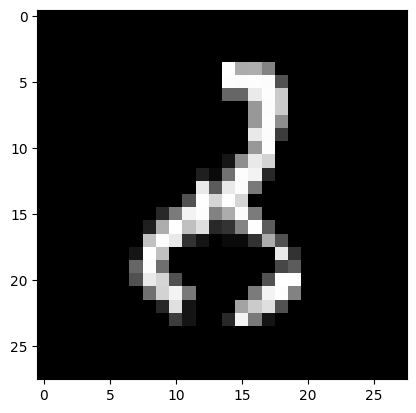

예측 : 7, 정답 : 8


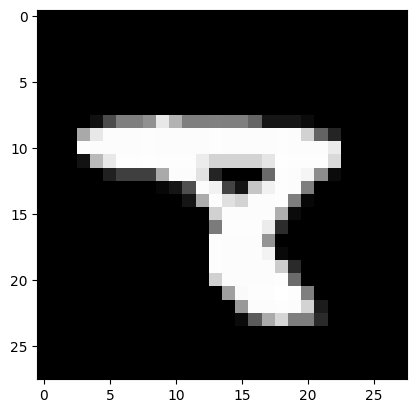

예측 : 0, 정답 : 5


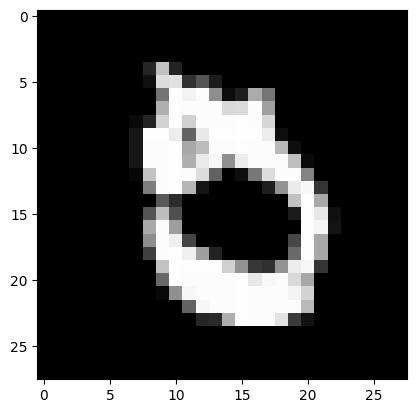

예측 : 9, 정답 : 7


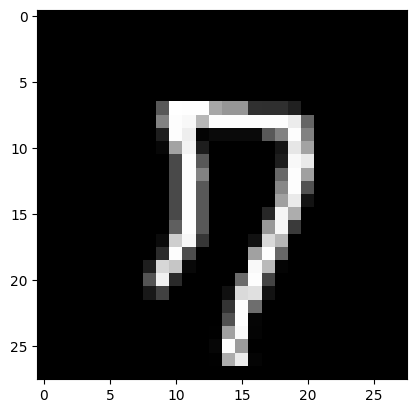

예측 : 0, 정답 : 2


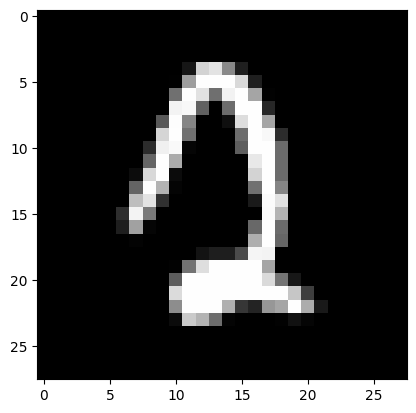

예측 : 8, 정답 : 7


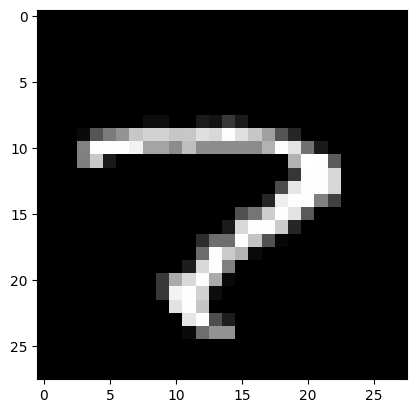

예측 : 9, 정답 : 8


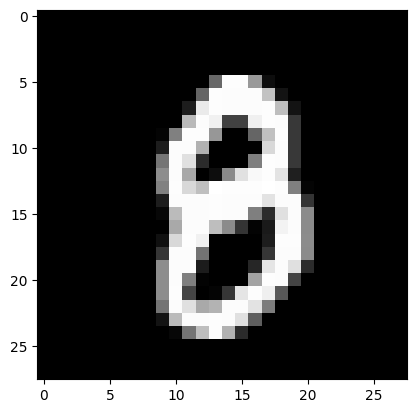

예측 : 9, 정답 : 5


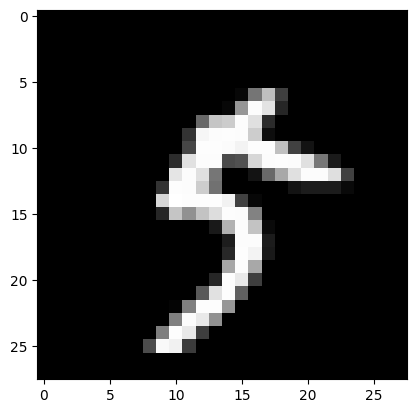

예측 : 8, 정답 : 3


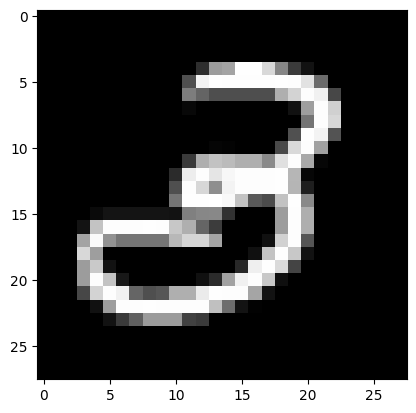

예측 : 8, 정답 : 2


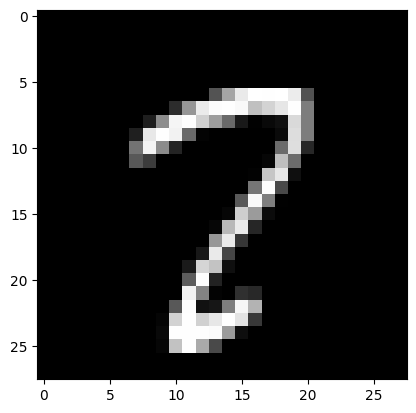

예측 : 3, 정답 : 2


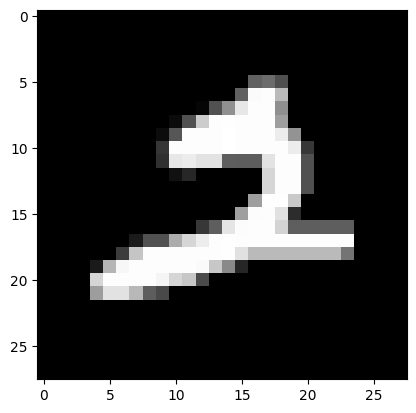

예측 : 3, 정답 : 1


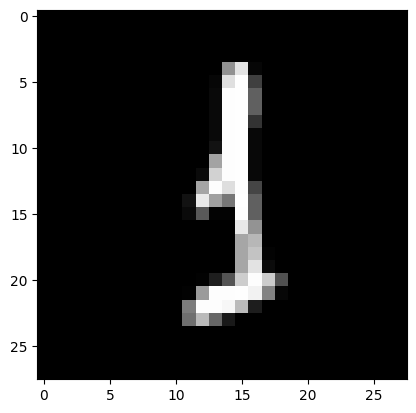

예측 : 3, 정답 : 2


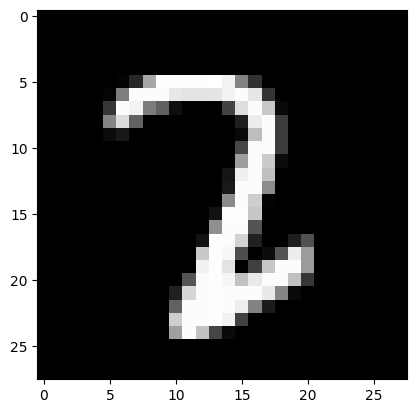

예측 : 9, 정답 : 8


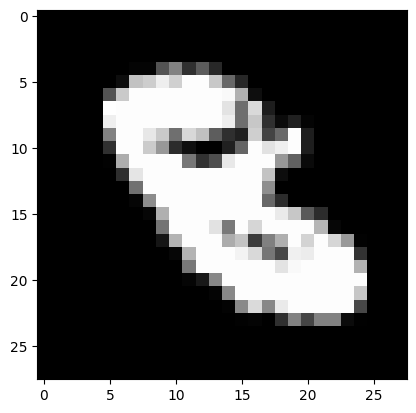

예측 : 7, 정답 : 2


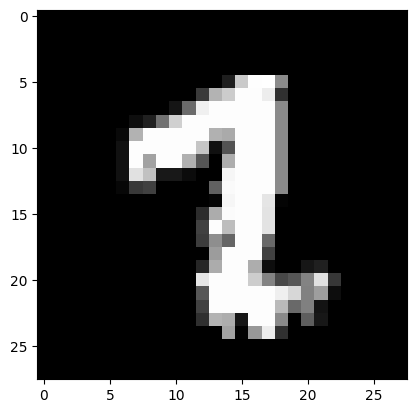

예측 : 2, 정답 : 7


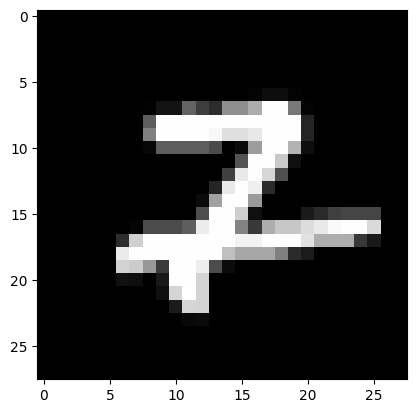

예측 : 4, 정답 : 9


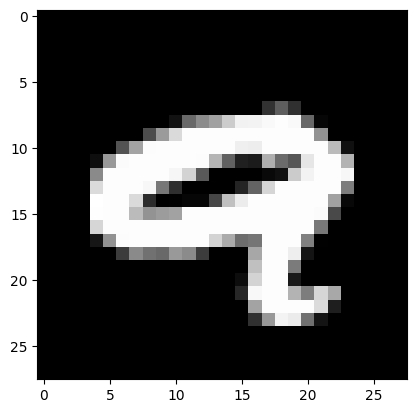

예측 : 8, 정답 : 3


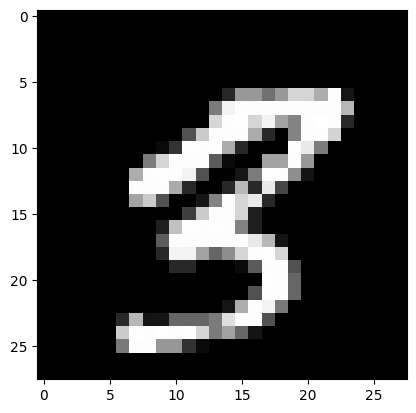

예측 : 1, 정답 : 2


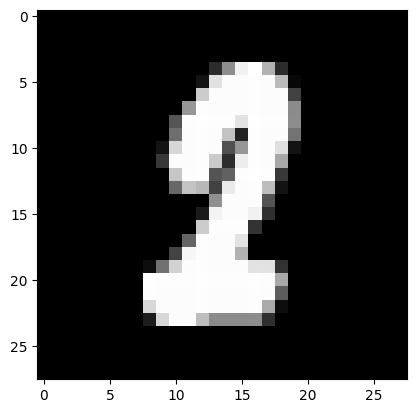

예측 : 5, 정답 : 9


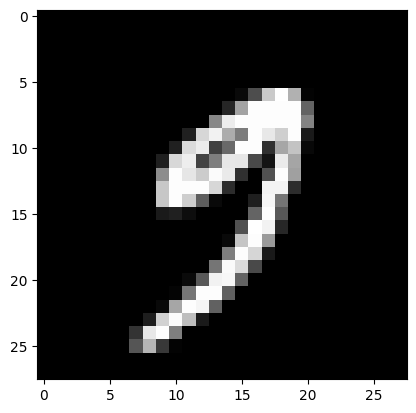

예측 : 5, 정답 : 8


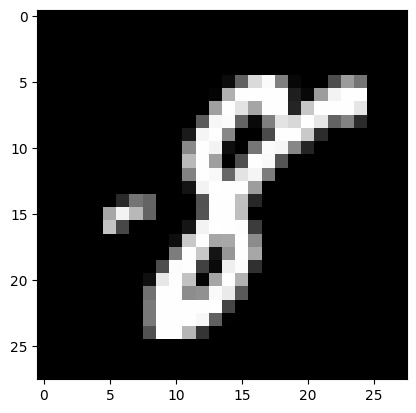

예측 : 0, 정답 : 2


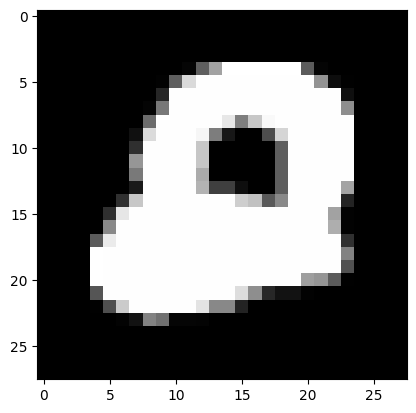

예측 : 6, 정답 : 5


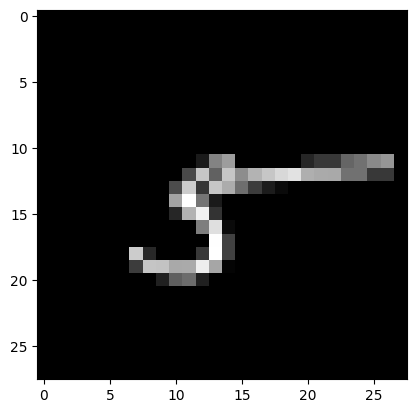

예측 : 9, 정답 : 4


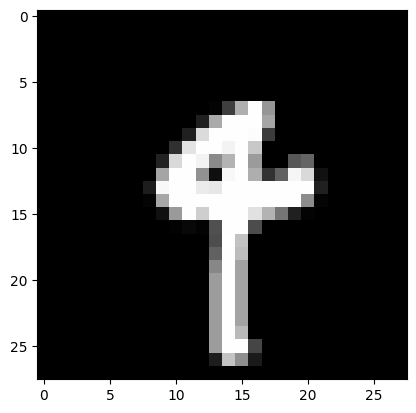

예측 : 0, 정답 : 8


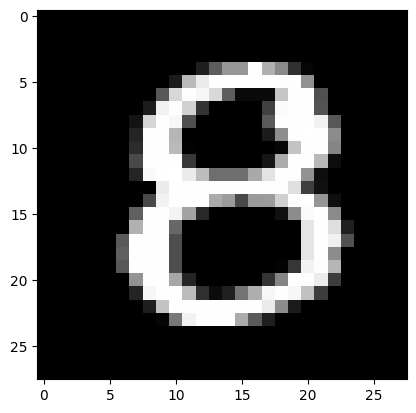

예측 : 6, 정답 : 4


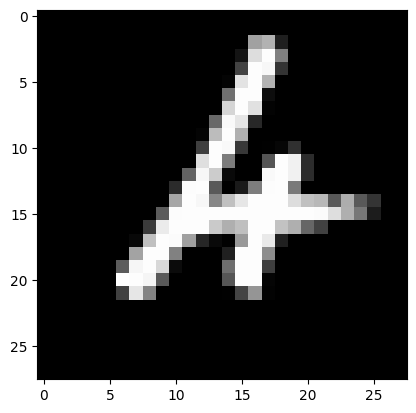

예측 : 5, 정답 : 0


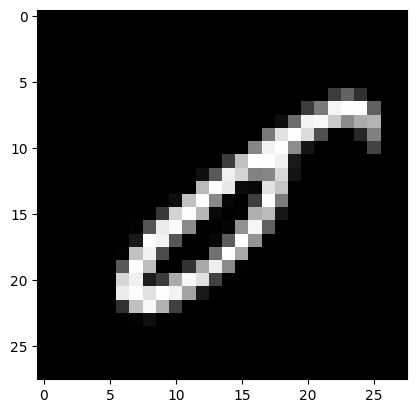

예측 : 9, 정답 : 7


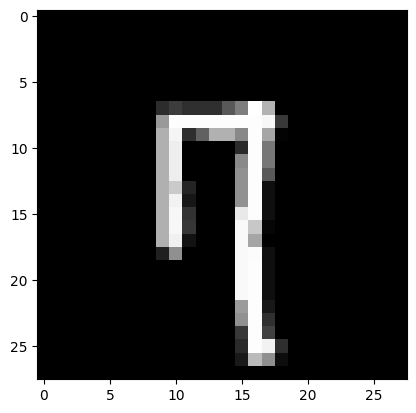

예측 : 5, 정답 : 6


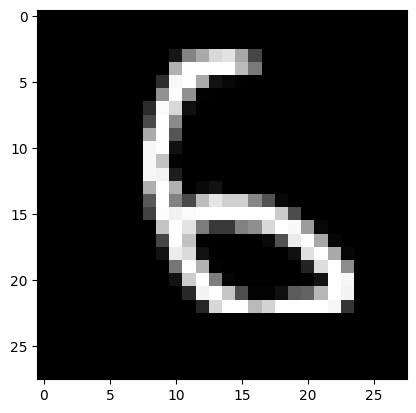

예측 : 6, 정답 : 0


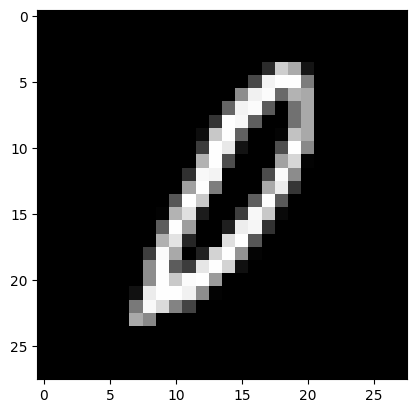

예측 : 1, 정답 : 7


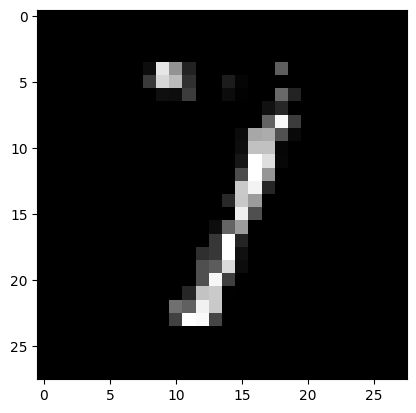

예측 : 1, 정답 : 6


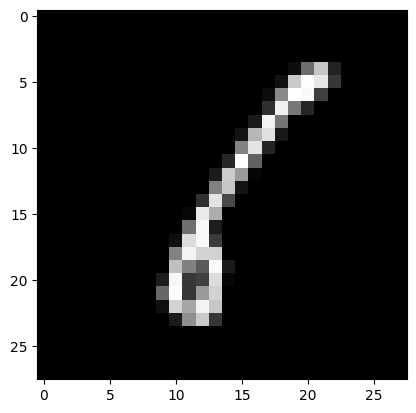

예측 : 3, 정답 : 5


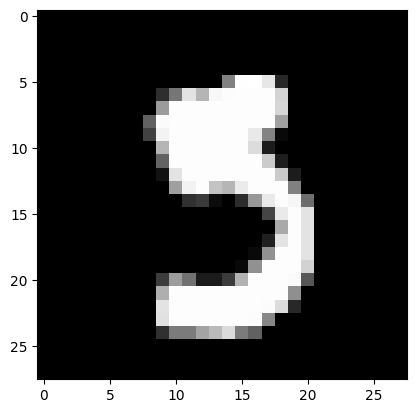

예측 : 1, 정답 : 9


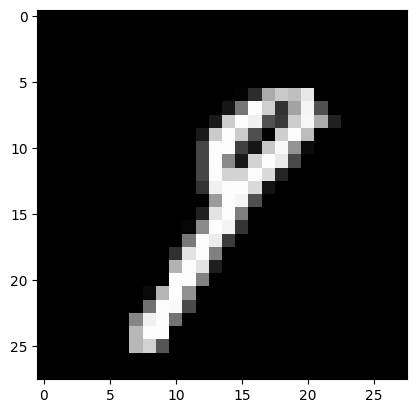

예측 : 7, 정답 : 1


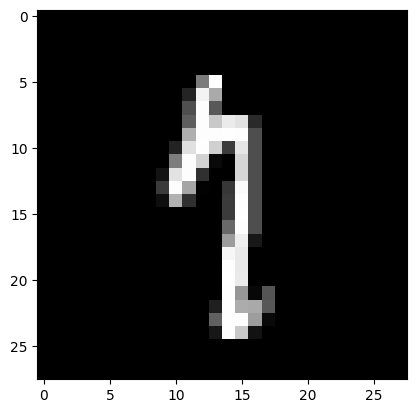

예측 : 2, 정답 : 3


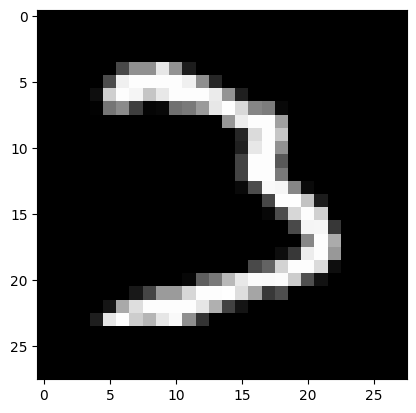

예측 : 7, 정답 : 2


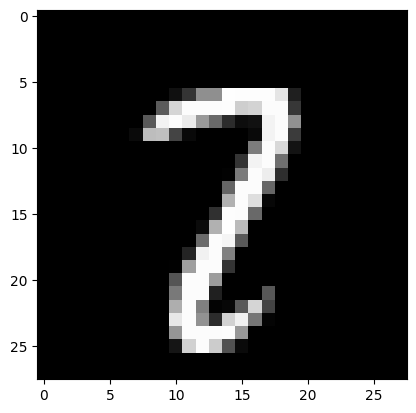

예측 : 8, 정답 : 9


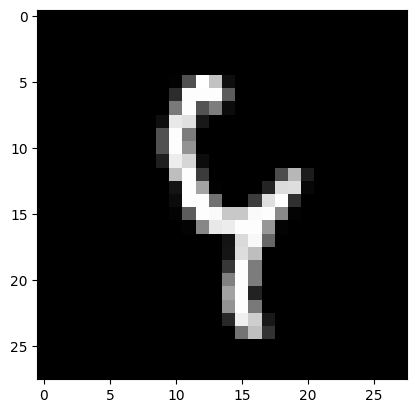

예측 : 1, 정답 : 9


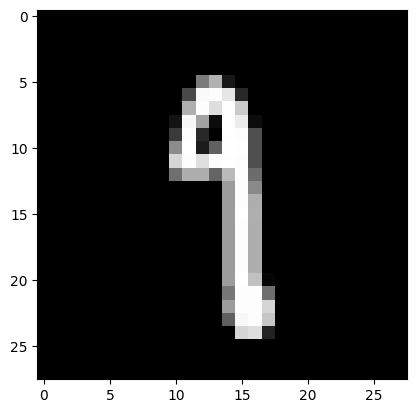

예측 : 9, 정답 : 4


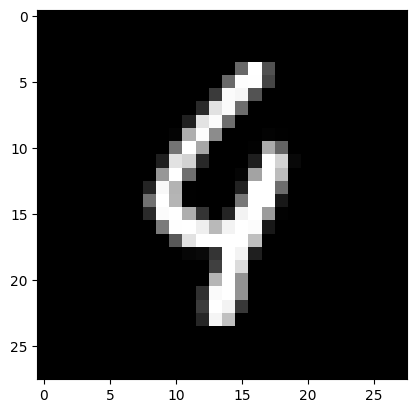

예측 : 9, 정답 : 8


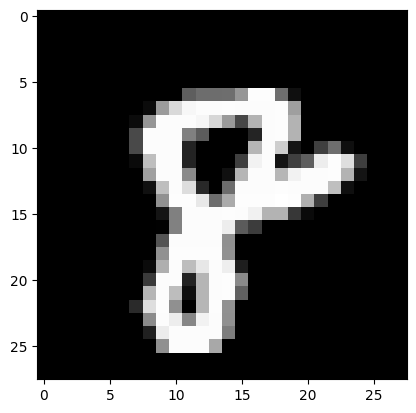

예측 : 3, 정답 : 9


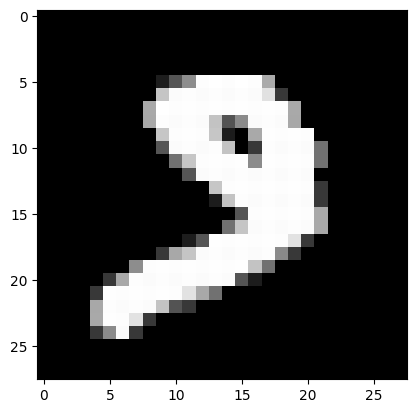

예측 : 0, 정답 : 8


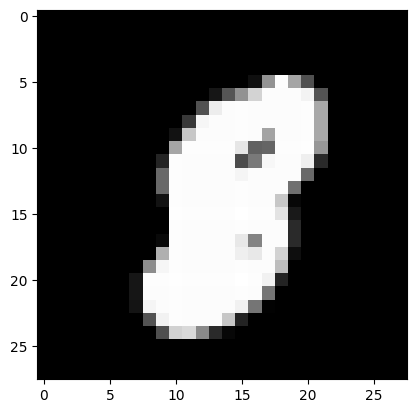

예측 : 3, 정답 : 5


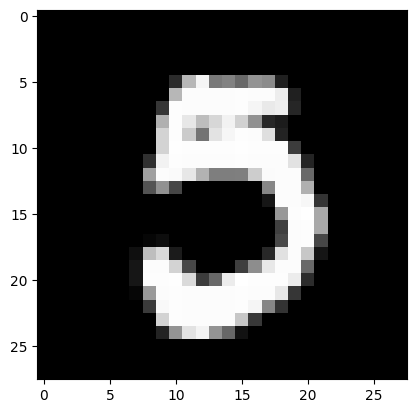

예측 : 2, 정답 : 3


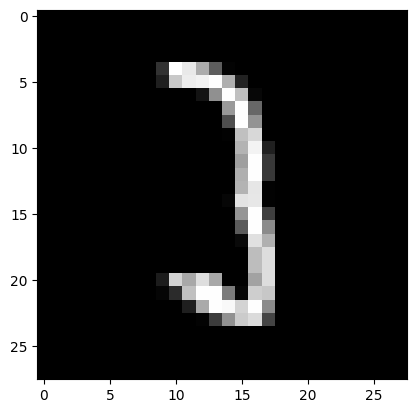

예측 : 5, 정답 : 3


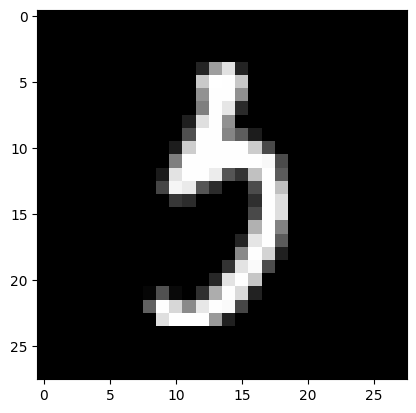

예측 : 4, 정답 : 2


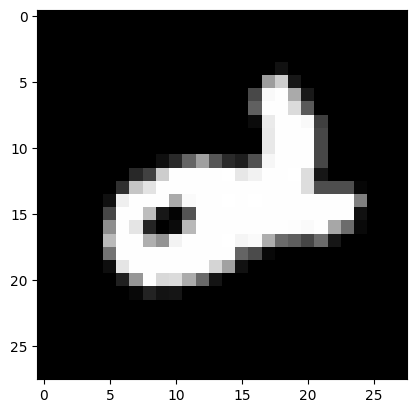

예측 : 6, 정답 : 2


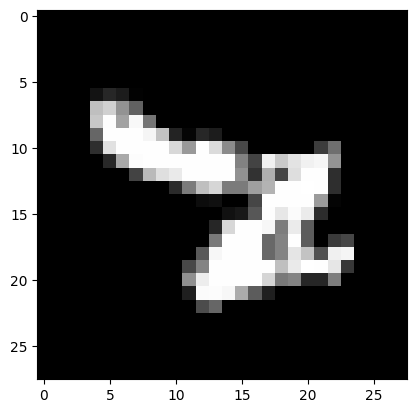

예측 : 5, 정답 : 3


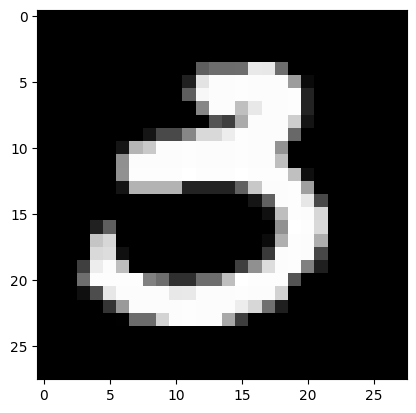

예측 : 8, 정답 : 2


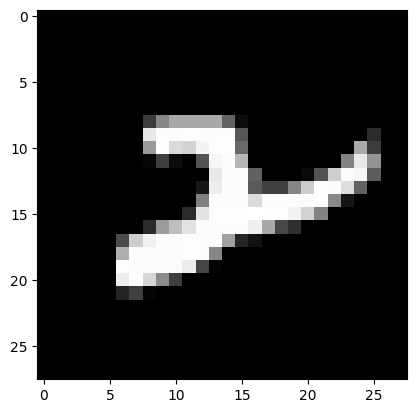

예측 : 8, 정답 : 2


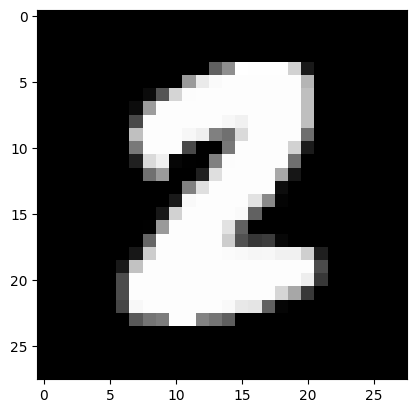

예측 : 3, 정답 : 5


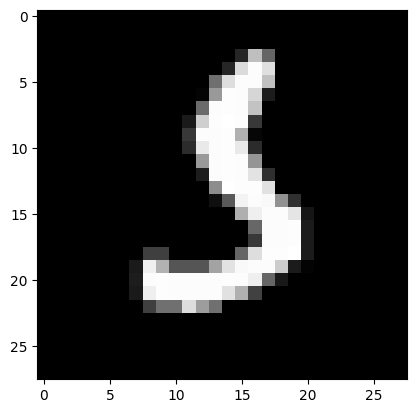

예측 : 2, 정답 : 7


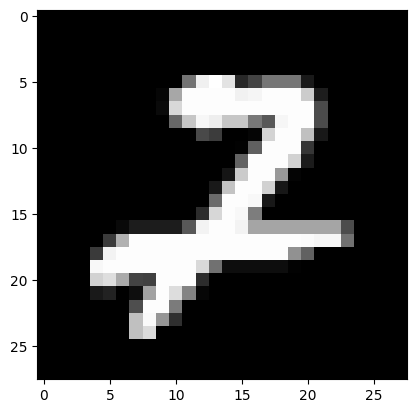

예측 : 5, 정답 : 9


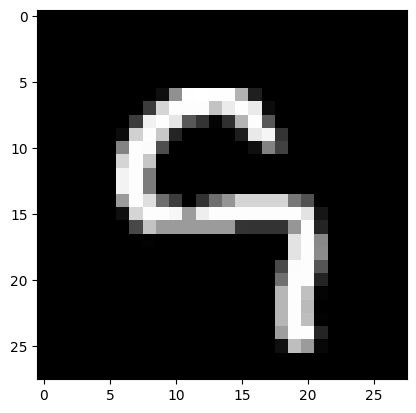

예측 : 1, 정답 : 9


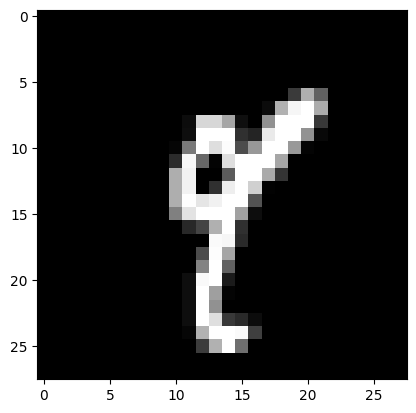

예측 : 6, 정답 : 5


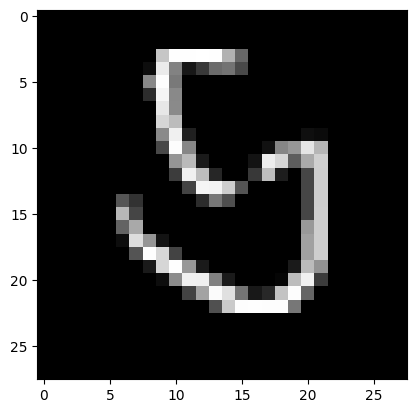

예측 : 2, 정답 : 7


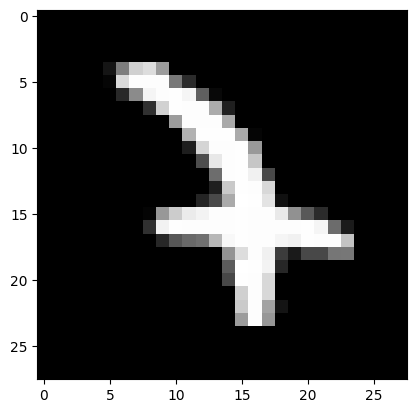

예측 : 3, 정답 : 4


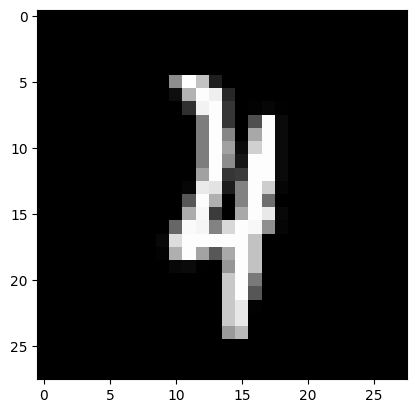

예측 : 9, 정답 : 4


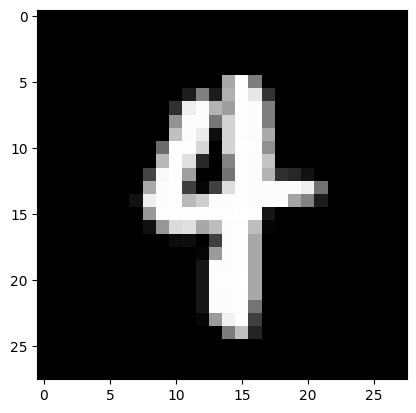

예측 : 5, 정답 : 3


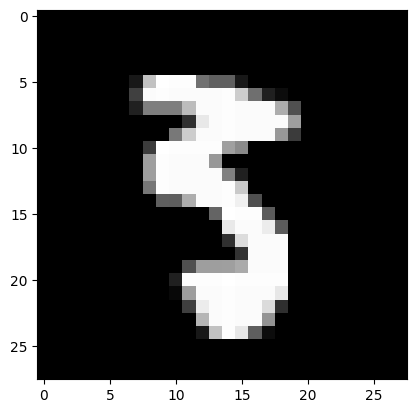

예측 : 9, 정답 : 8


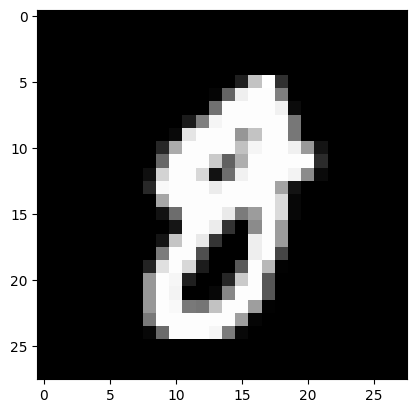

예측 : 0, 정답 : 6


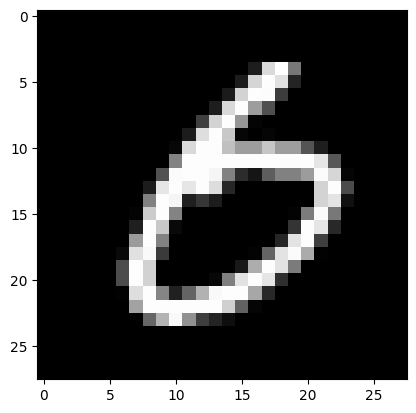

예측 : 1, 정답 : 6


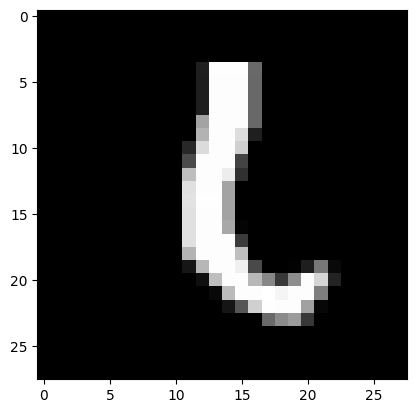

예측 : 5, 정답 : 3


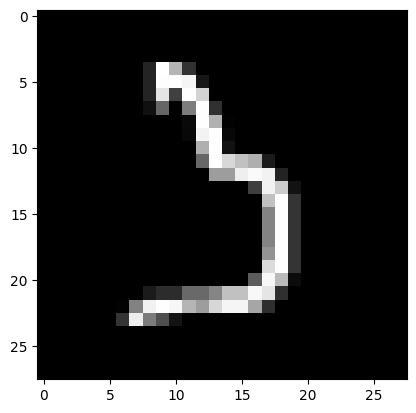

예측 : 8, 정답 : 2


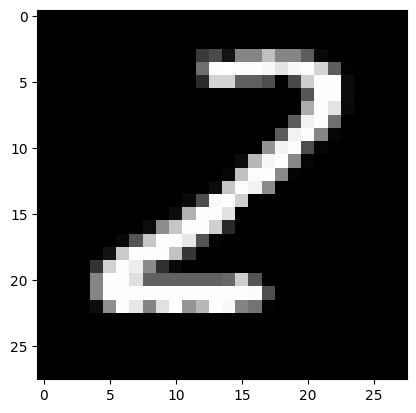

예측 : 5, 정답 : 8


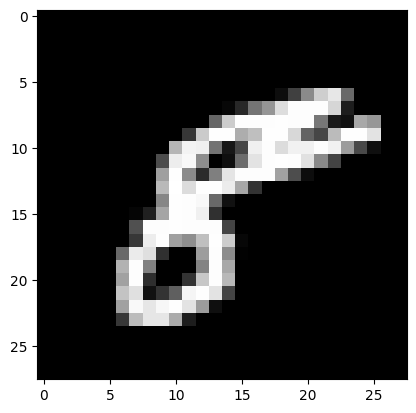

예측 : 4, 정답 : 5


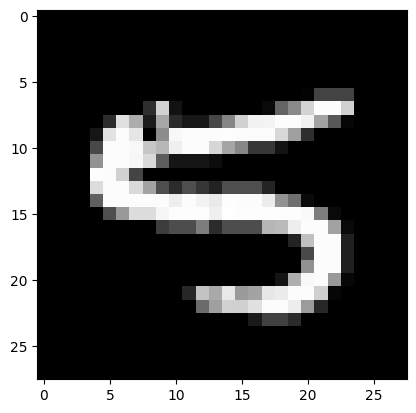

예측 : 9, 정답 : 4


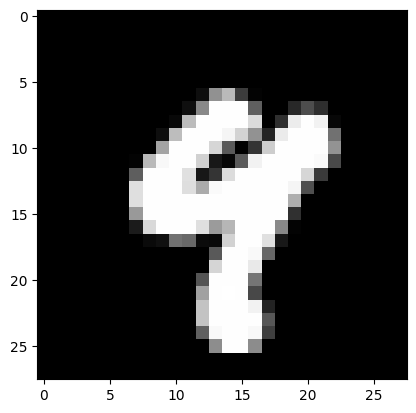

예측 : 2, 정답 : 7


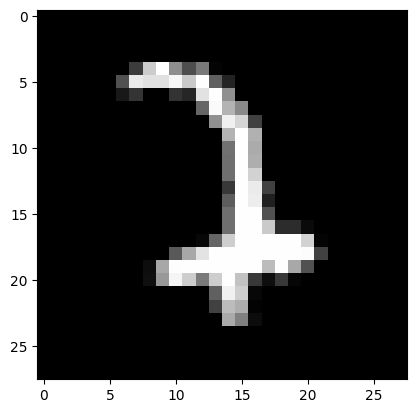

예측 : 1, 정답 : 6


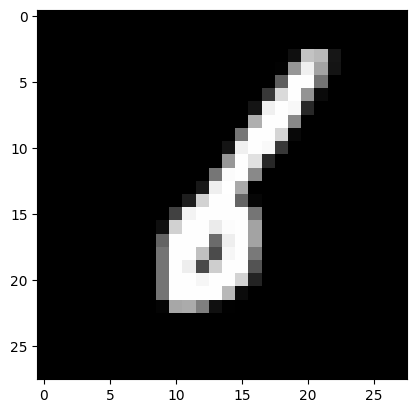

예측 : 6, 정답 : 8


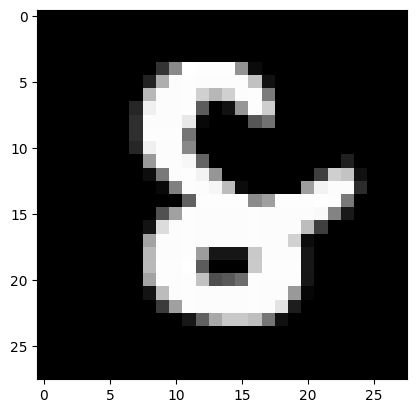

예측 : 6, 정답 : 2


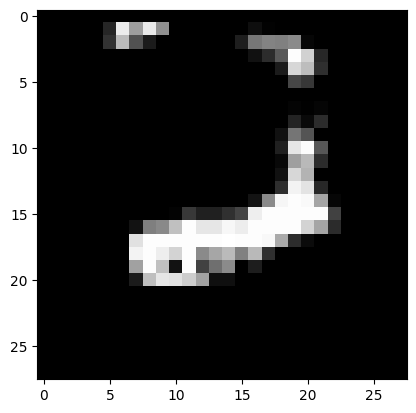

예측 : 9, 정답 : 7


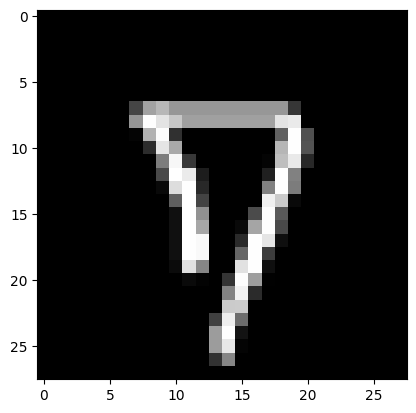

예측 : 5, 정답 : 3


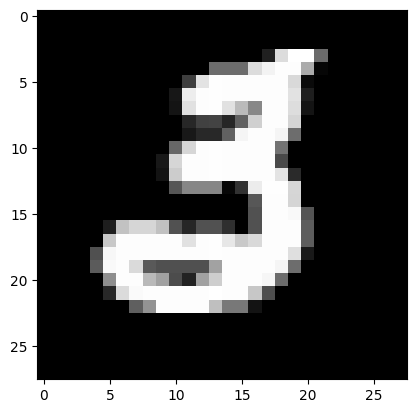

예측 : 6, 정답 : 1


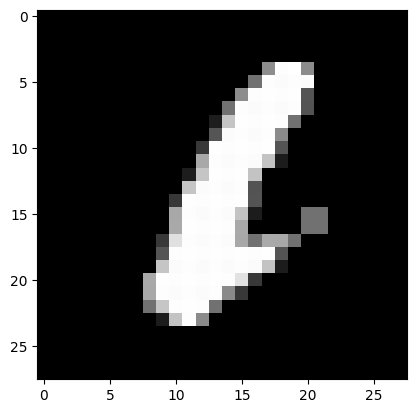

예측 : 4, 정답 : 5


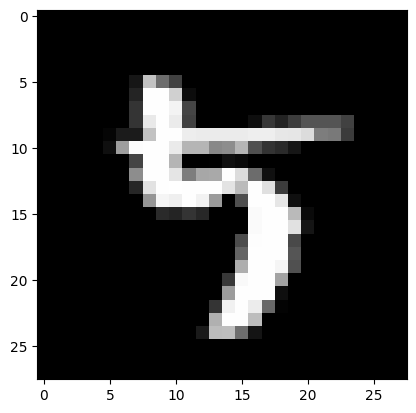

예측 : 5, 정답 : 3


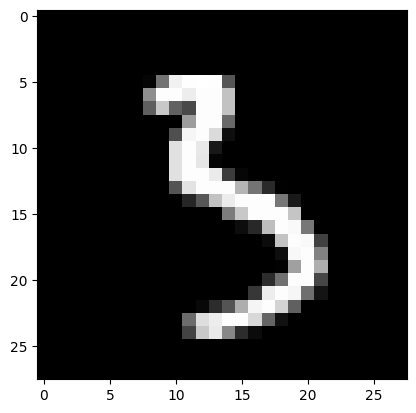

예측 : 9, 정답 : 4


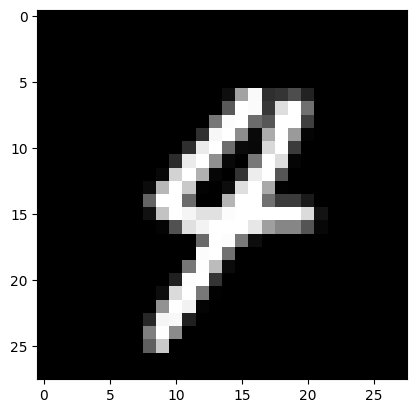

예측 : 6, 정답 : 4


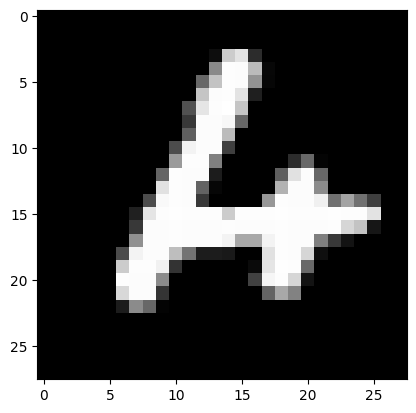

예측 : 9, 정답 : 8


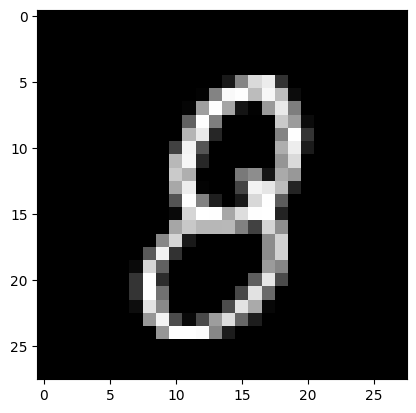

예측 : 6, 정답 : 0


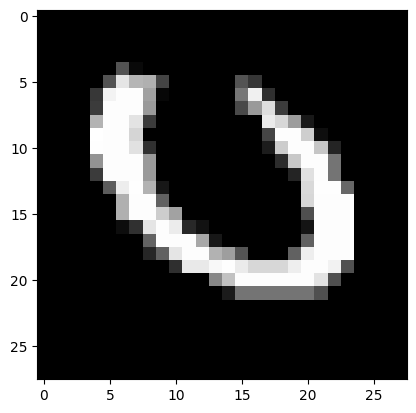

예측 : 1, 정답 : 9


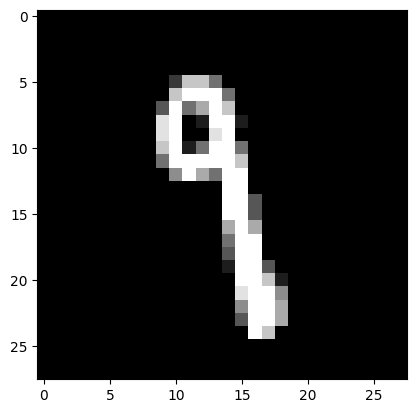

예측 : 4, 정답 : 6


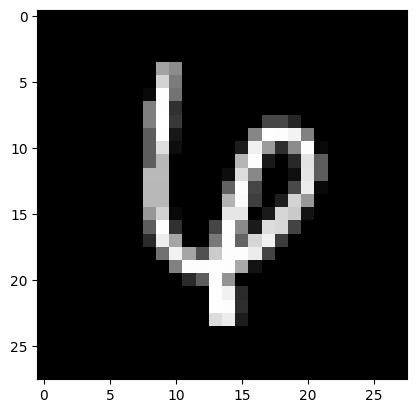

예측 : 7, 정답 : 2


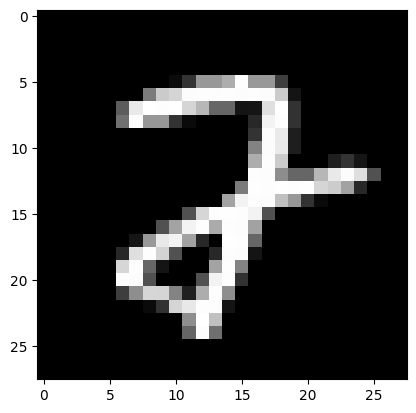

예측 : 5, 정답 : 9


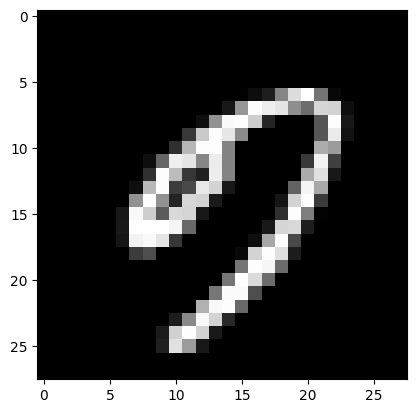

예측 : 8, 정답 : 2


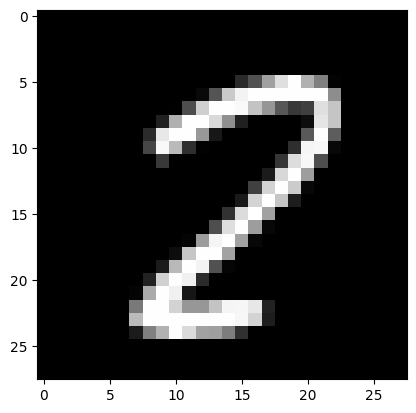

예측 : 1, 정답 : 8


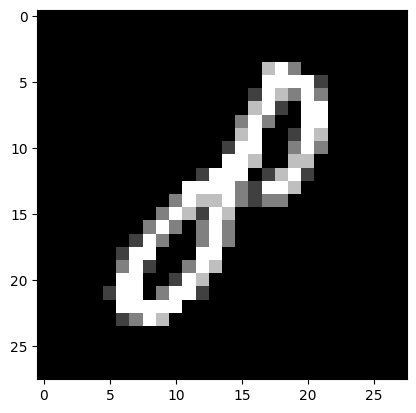

예측 : 3, 정답 : 2


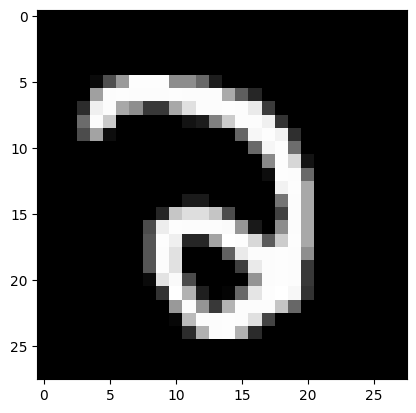

예측 : 5, 정답 : 6


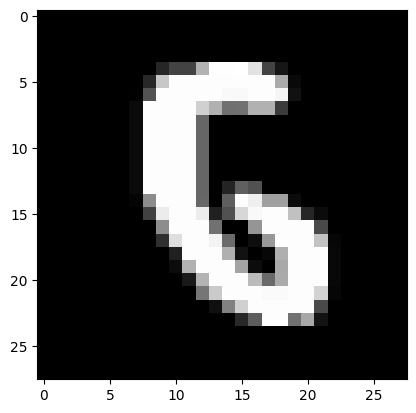

예측 : 4, 정답 : 7


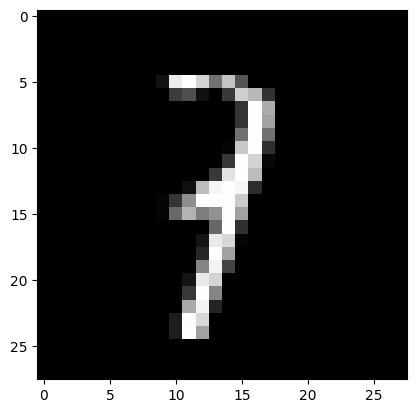

예측 : 5, 정답 : 8


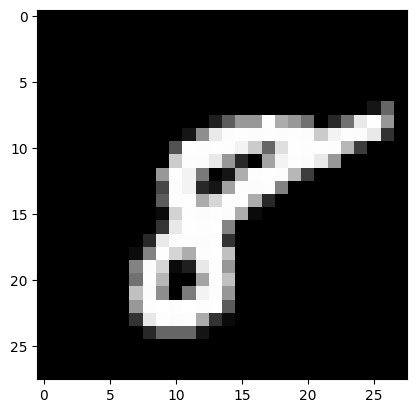

예측 : 7, 정답 : 2


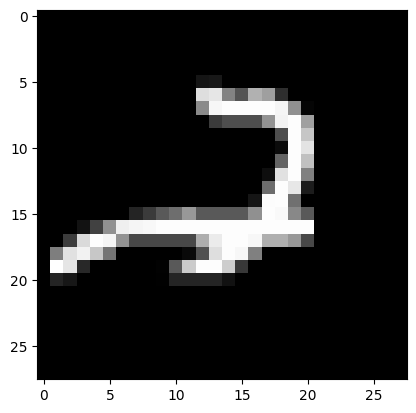

예측 : 4, 정답 : 2


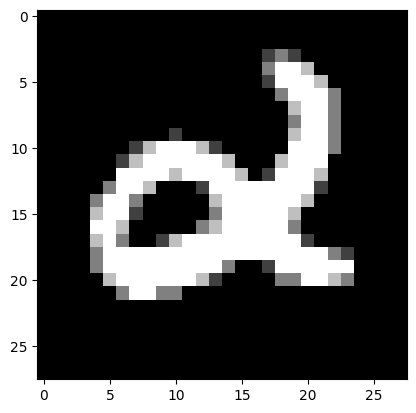

예측 : 0, 정답 : 8


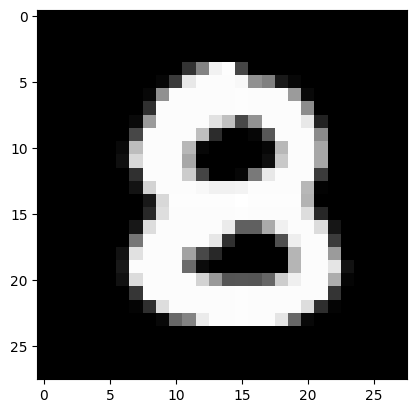

예측 : 6, 정답 : 4


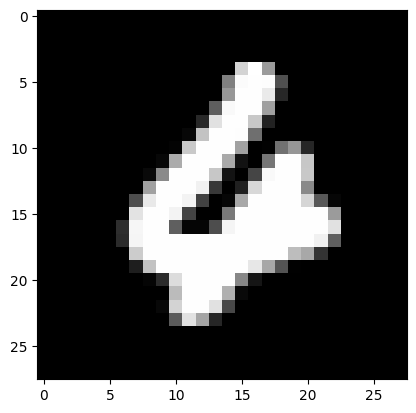

예측 : 6, 정답 : 8


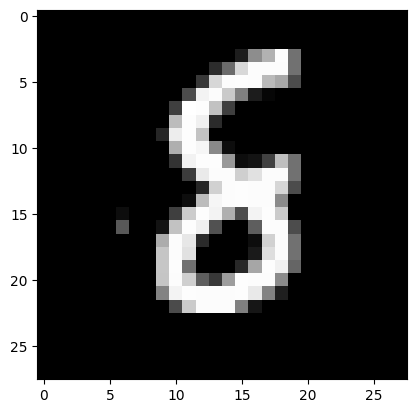

예측 : 9, 정답 : 7


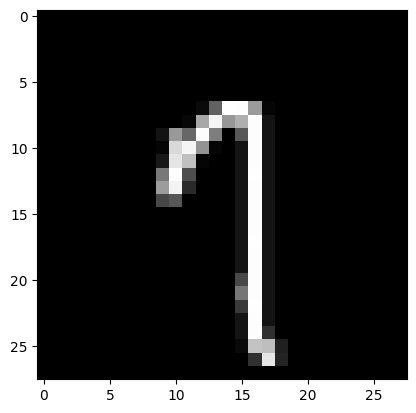

예측 : 8, 정답 : 5


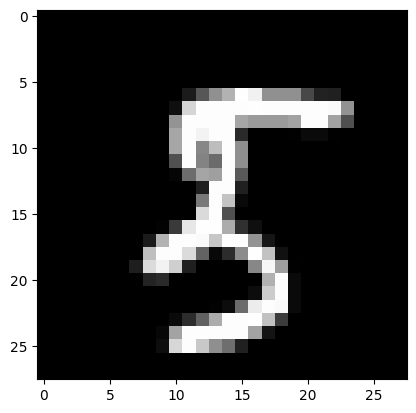

예측 : 8, 정답 : 7


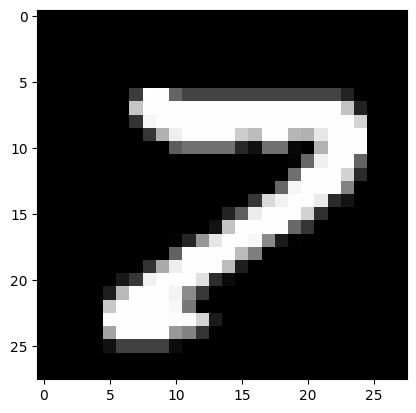

예측 : 9, 정답 : 4


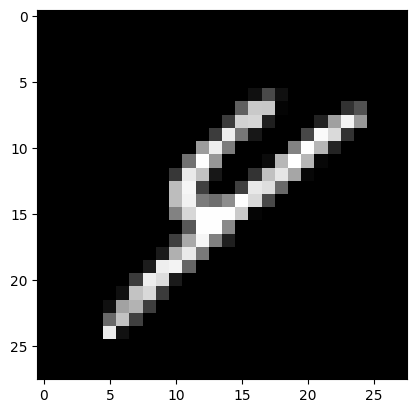

예측 : 3, 정답 : 9


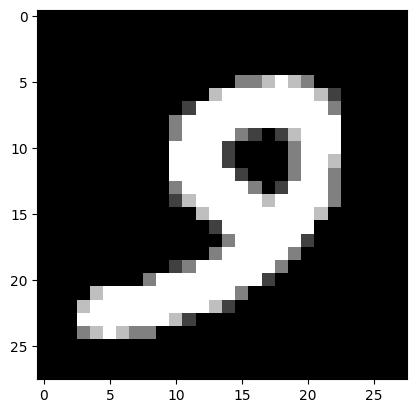

예측 : 0, 정답 : 3


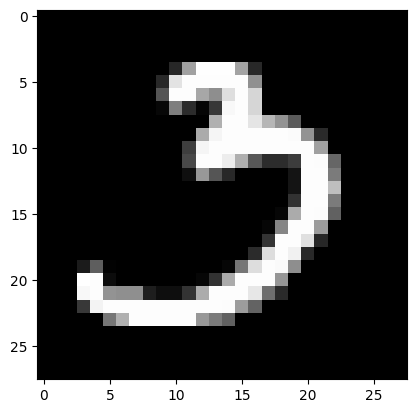

예측 : 9, 정답 : 3


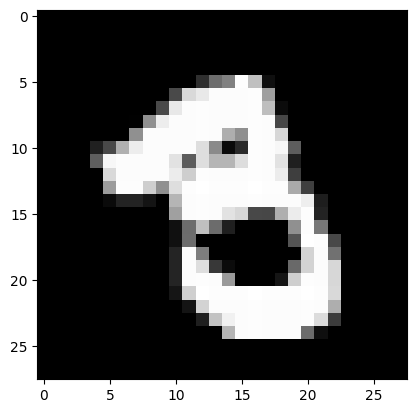

예측 : 6, 정답 : 5


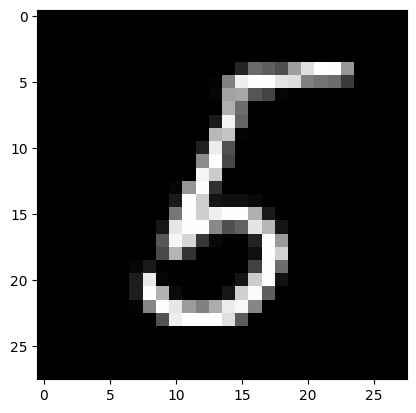

예측 : 3, 정답 : 2


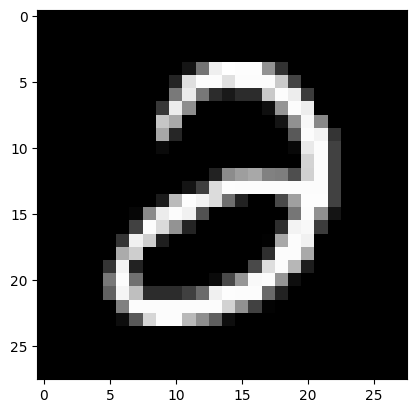

예측 : 9, 정답 : 3


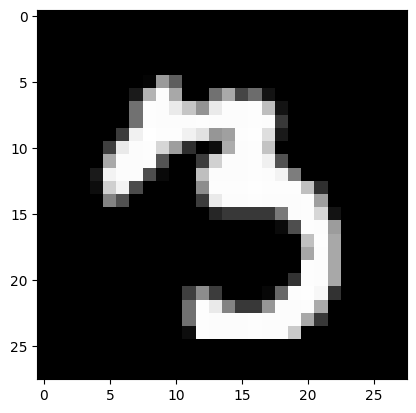

예측 : 3, 정답 : 2


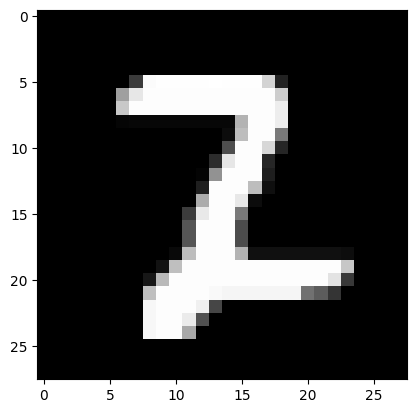

예측 : 5, 정답 : 8


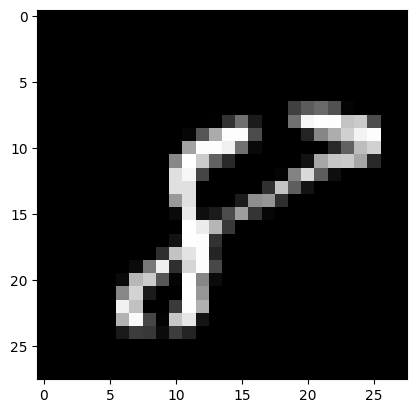

예측 : 8, 정답 : 2


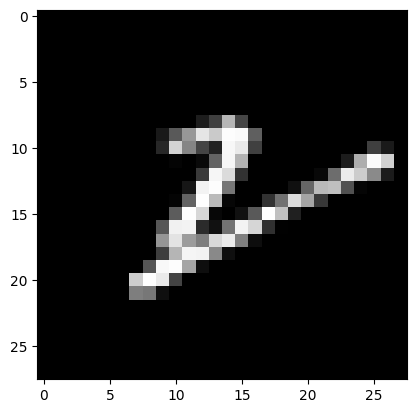

예측 : 5, 정답 : 8


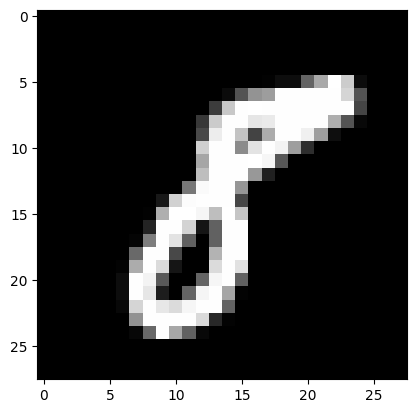

예측 : 0, 정답 : 2


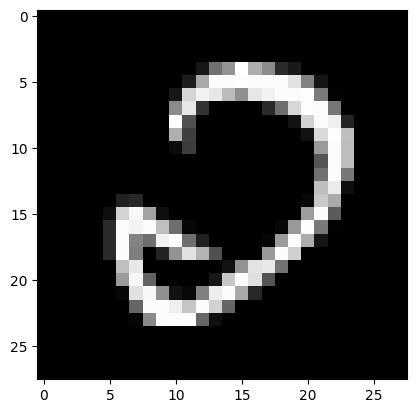

예측 : 0, 정답 : 6


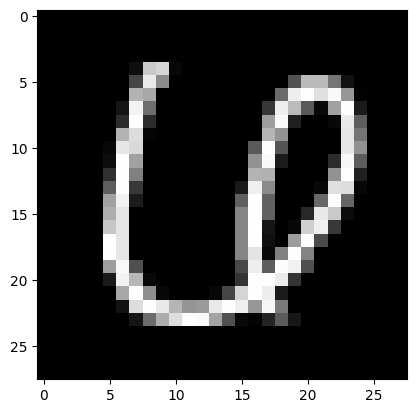

예측 : 4, 정답 : 9


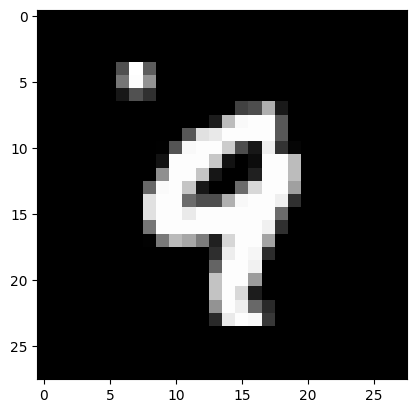

예측 : 3, 정답 : 8


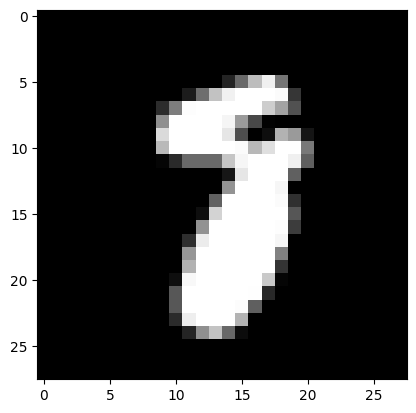

예측 : 7, 정답 : 9


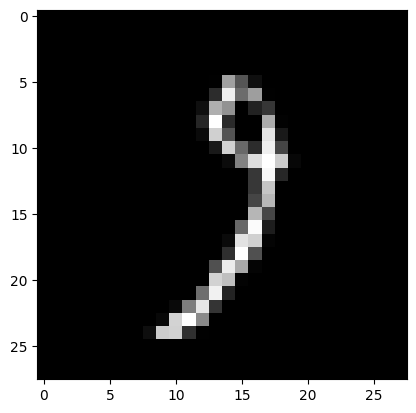

예측 : 8, 정답 : 2


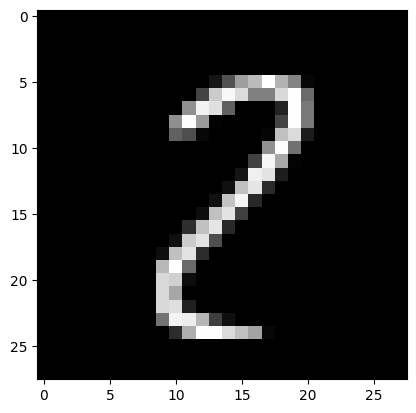

예측 : 8, 정답 : 7


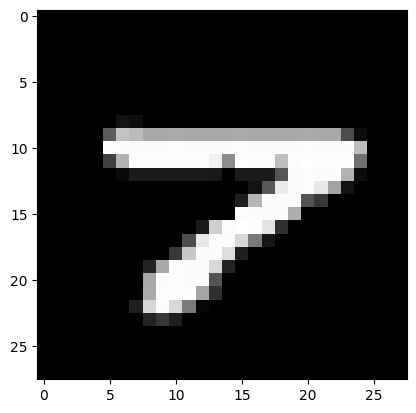

예측 : 2, 정답 : 1


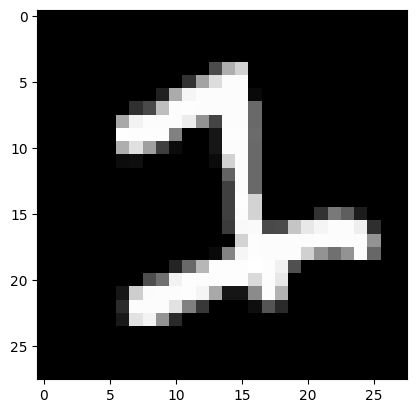

예측 : 2, 정답 : 7


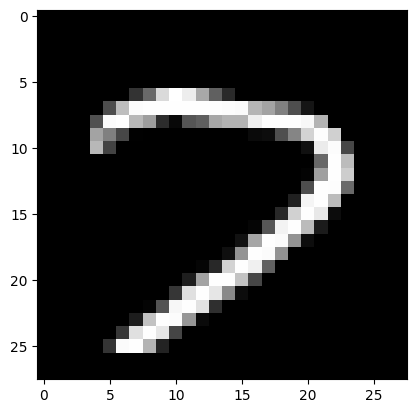

예측 : 5, 정답 : 4


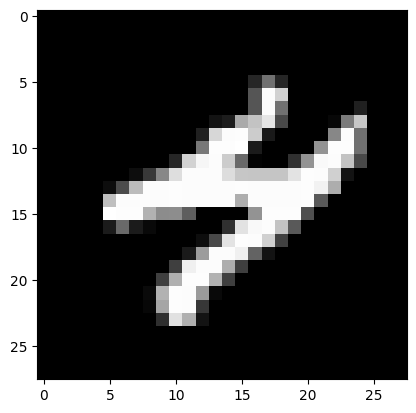

예측 : 3, 정답 : 1


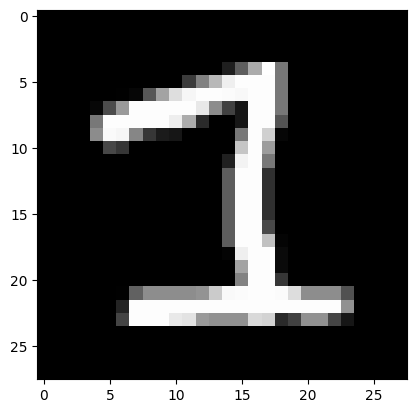

예측 : 4, 정답 : 2


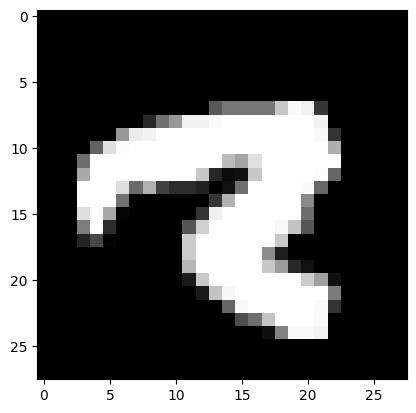

예측 : 9, 정답 : 8


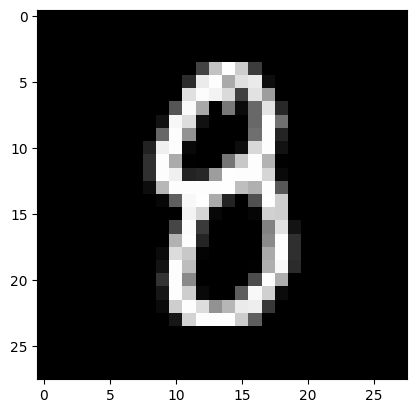

예측 : 9, 정답 : 3


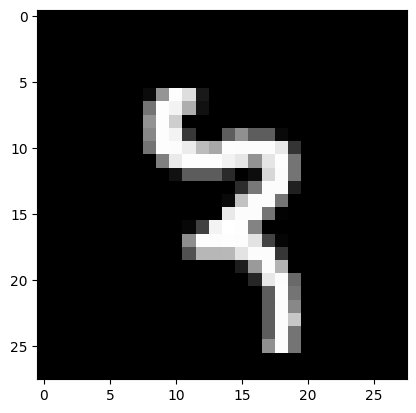

예측 : 9, 정답 : 3


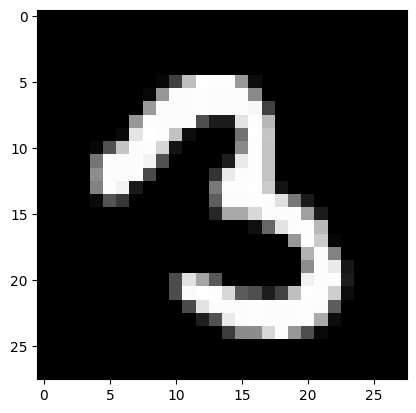

예측 : 8, 정답 : 9


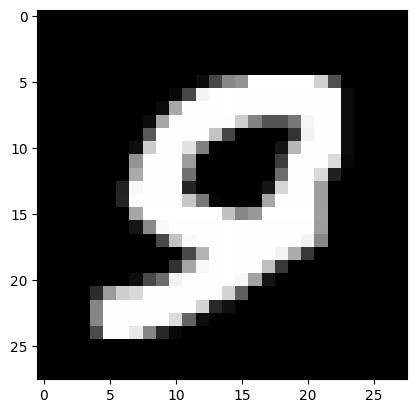

예측 : 1, 정답 : 2


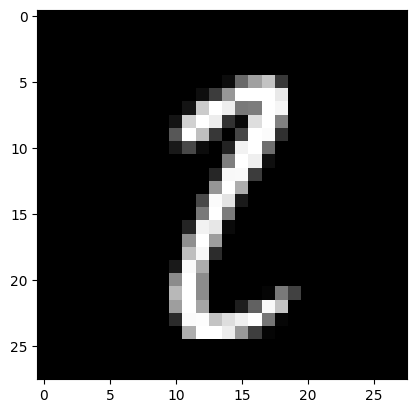

예측 : 5, 정답 : 9


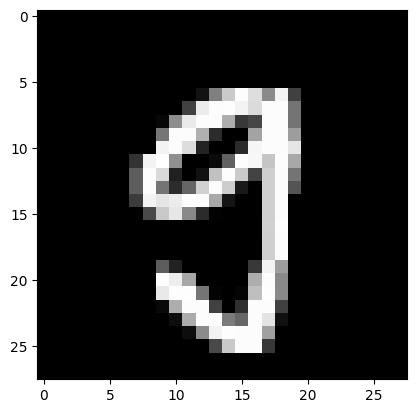

예측 : 3, 정답 : 2


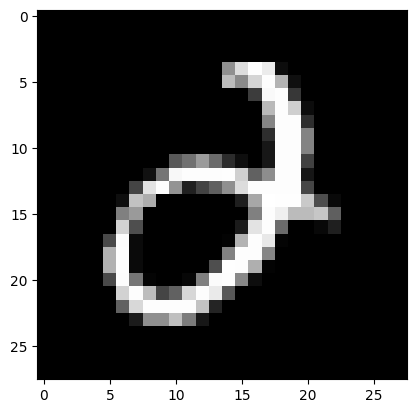

예측 : 6, 정답 : 5


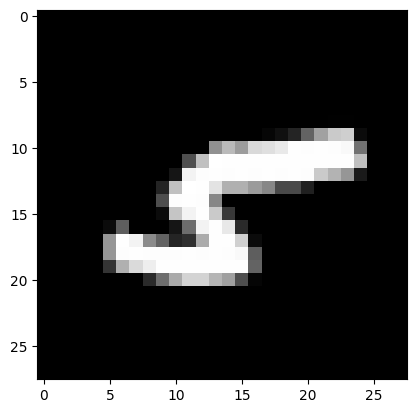

예측 : 4, 정답 : 8


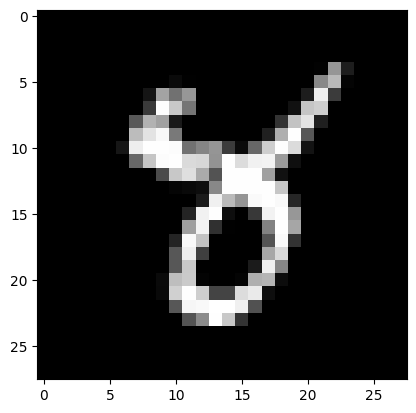

예측 : 5, 정답 : 8


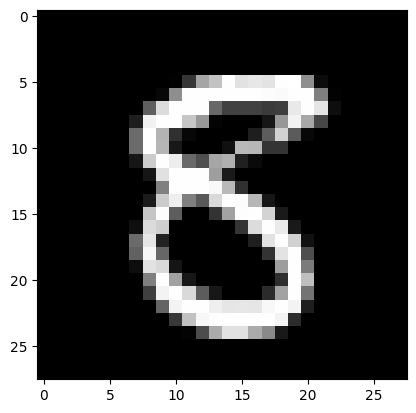

예측 : 9, 정답 : 7


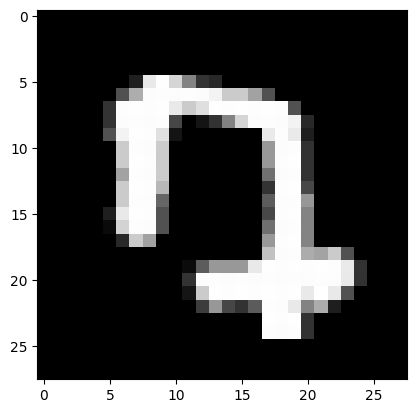

예측 : 9, 정답 : 7


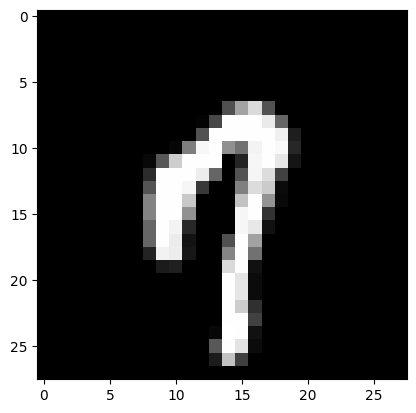

예측 : 6, 정답 : 5


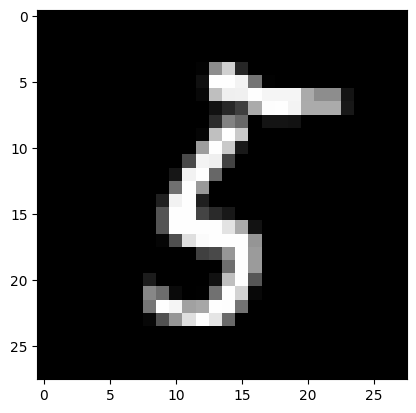

예측 : 6, 정답 : 4


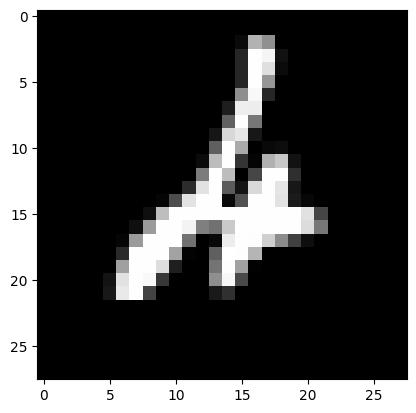

예측 : 0, 정답 : 9


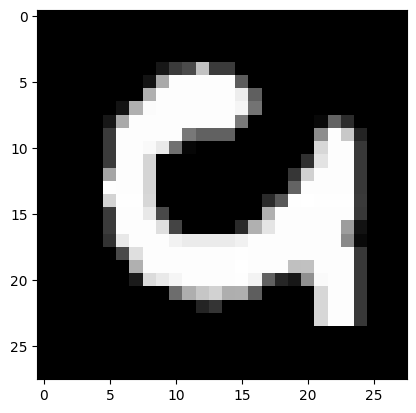

예측 : 7, 정답 : 9


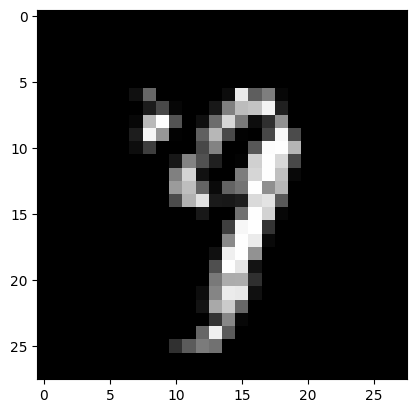

예측 : 4, 정답 : 6


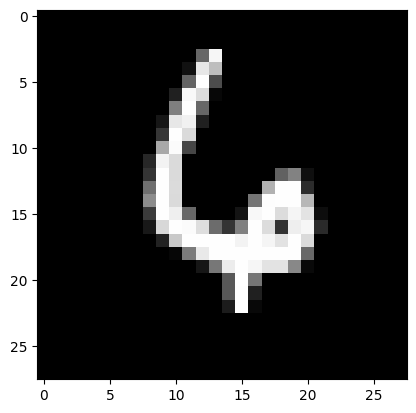

예측 : 0, 정답 : 2


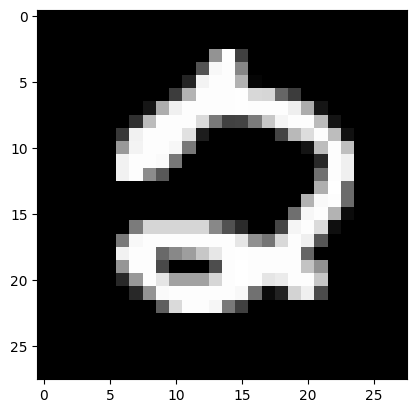

예측 : 3, 정답 : 8


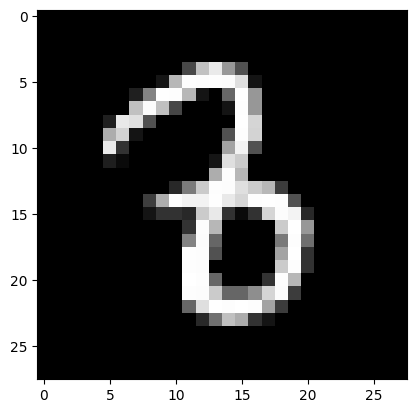

예측 : 9, 정답 : 7


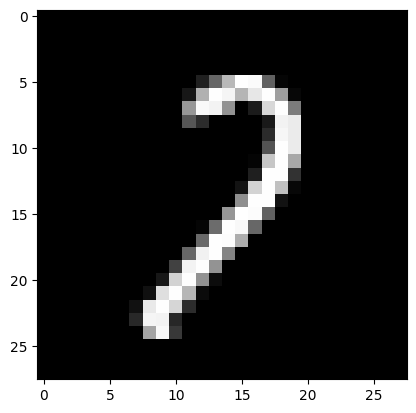

예측 : 0, 정답 : 8


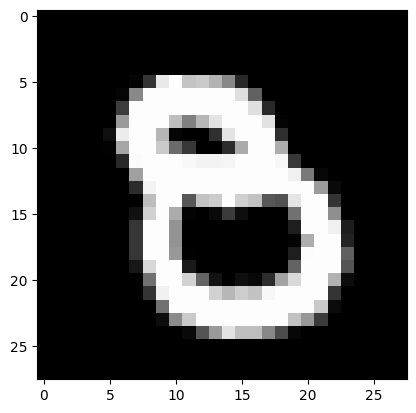

예측 : 9, 정답 : 8


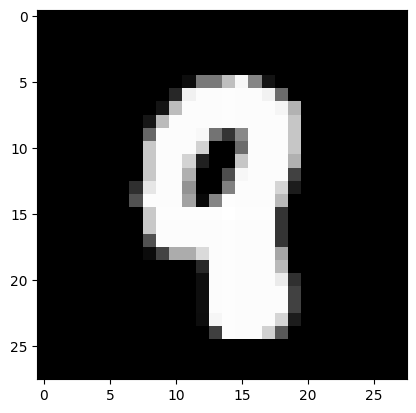

예측 : 5, 정답 : 2


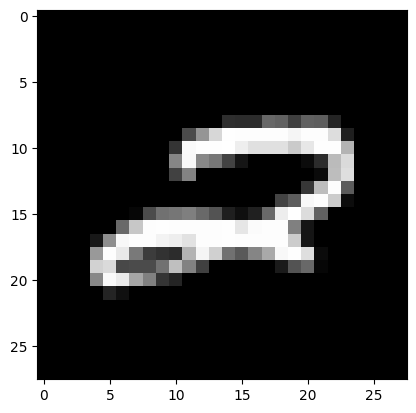

예측 : 4, 정답 : 8


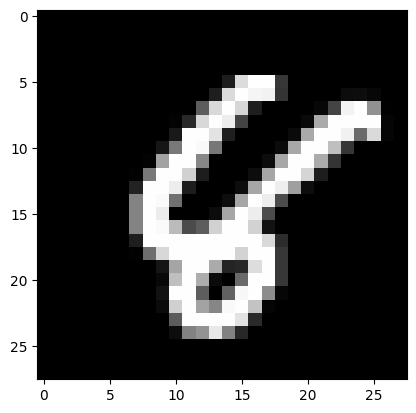

예측 : 0, 정답 : 8


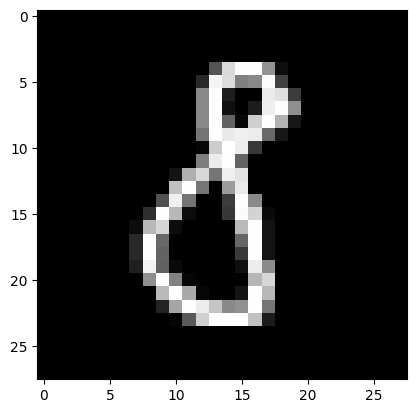

예측 : 2, 정답 : 4


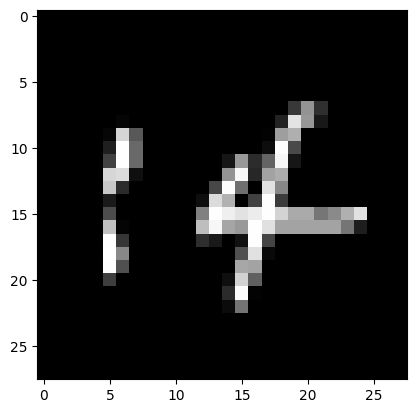

예측 : 5, 정답 : 9


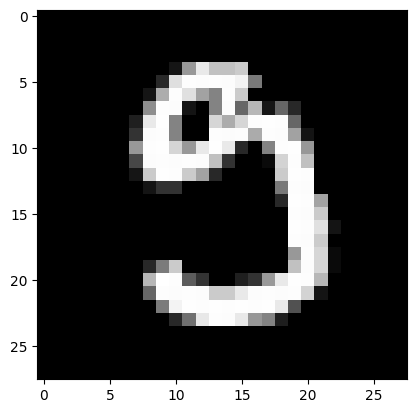

예측 : 8, 정답 : 1


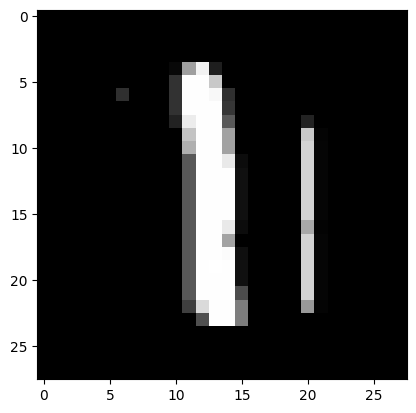

예측 : 3, 정답 : 8


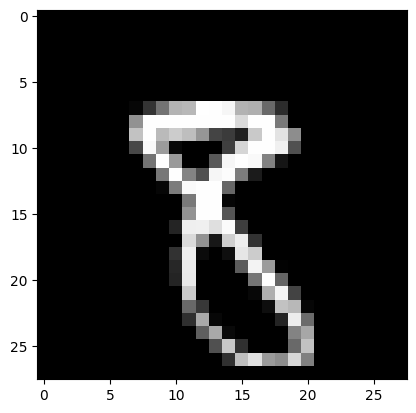

예측 : 6, 정답 : 4


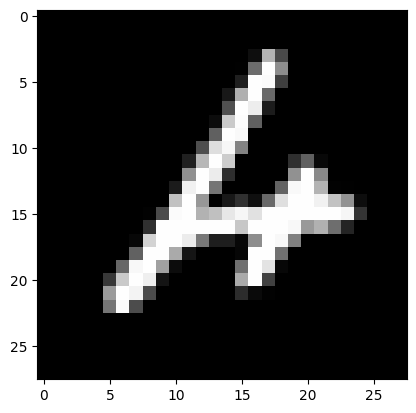

예측 : 5, 정답 : 6


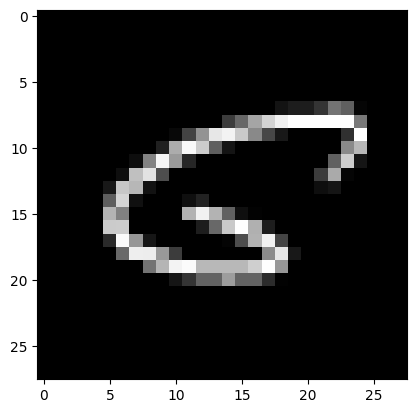

예측 : 0, 정답 : 8


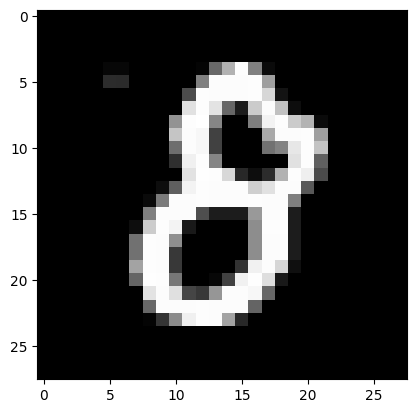

예측 : 2, 정답 : 6


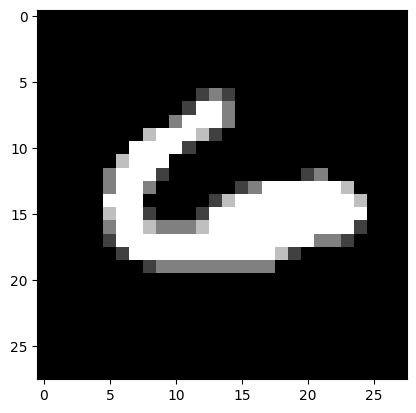

예측 : 4, 정답 : 9


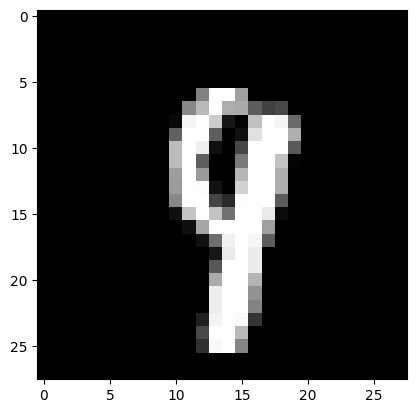

예측 : 6, 정답 : 2


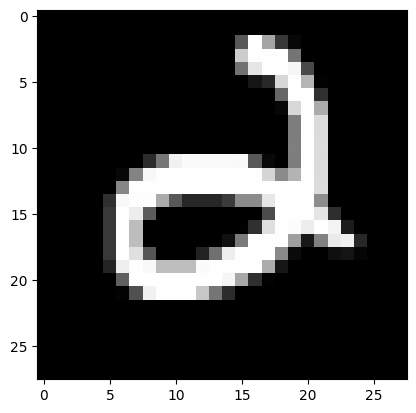

예측 : 4, 정답 : 2


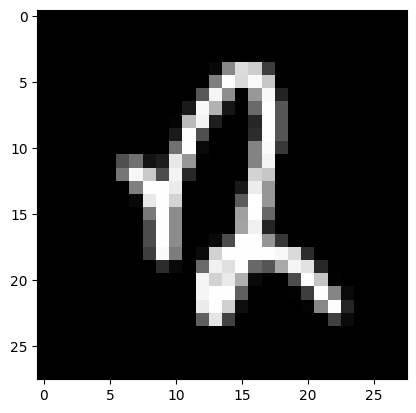

예측 : 0, 정답 : 4


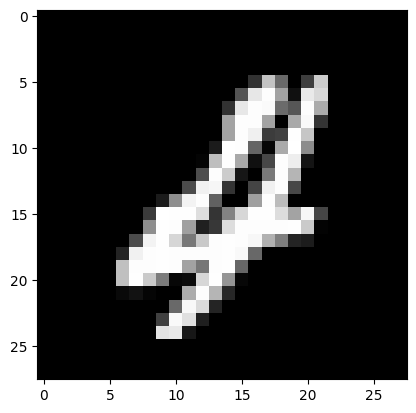

예측 : 9, 정답 : 3


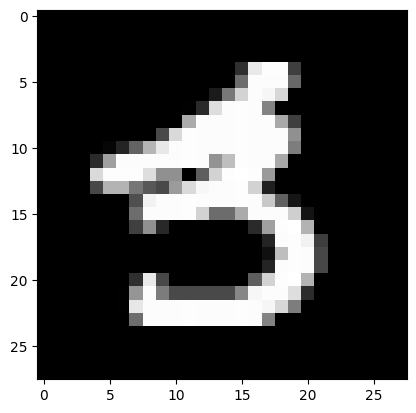

예측 : 5, 정답 : 8


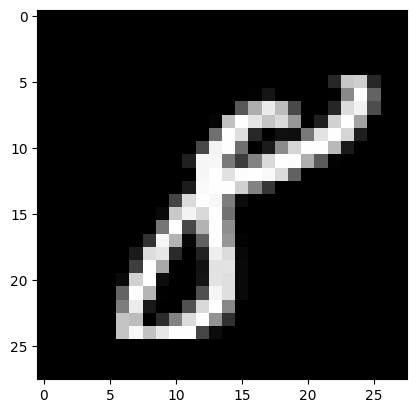

예측 : 3, 정답 : 2


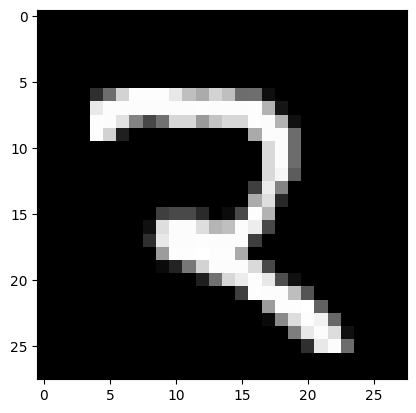

예측 : 9, 정답 : 7


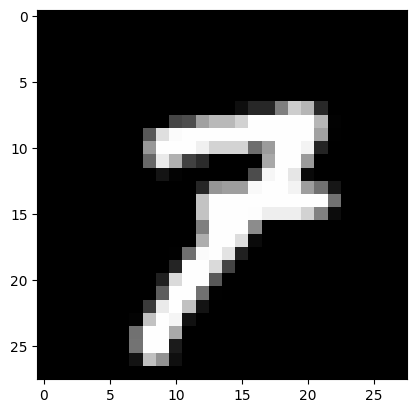

예측 : 8, 정답 : 5


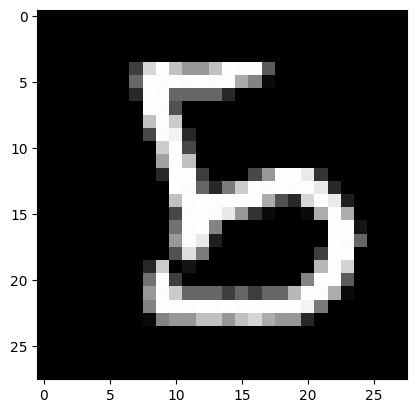

예측 : 5, 정답 : 6


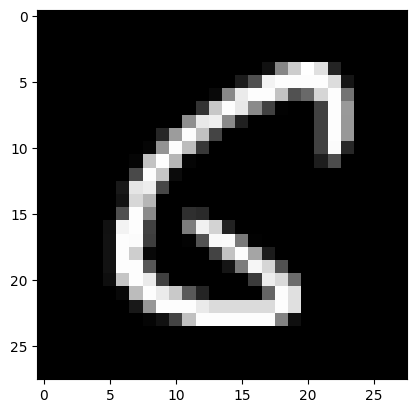

예측 : 9, 정답 : 4


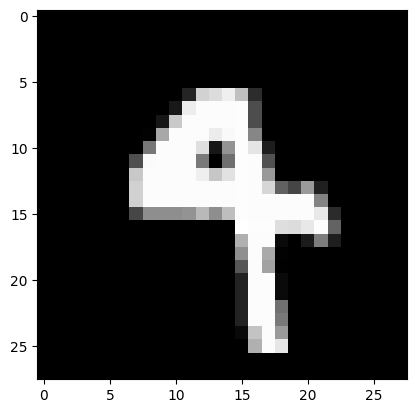

예측 : 1, 정답 : 8


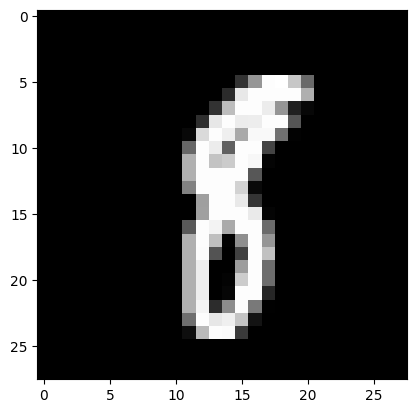

예측 : 3, 정답 : 5


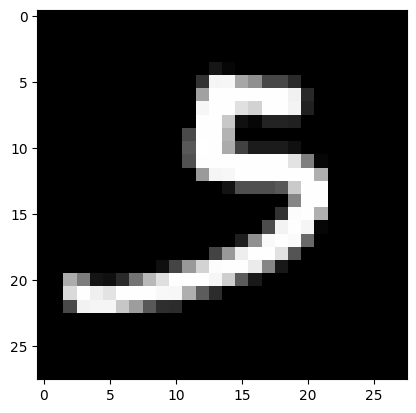

예측 : 0, 정답 : 7


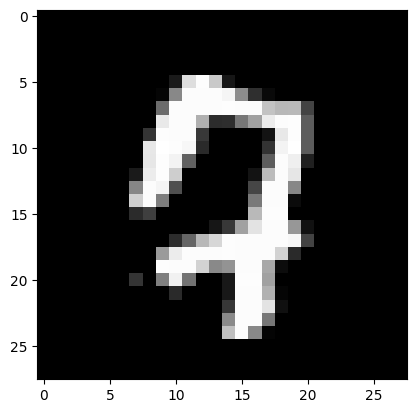

예측 : 5, 정답 : 8


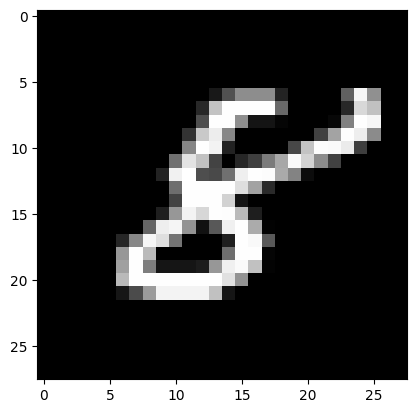

예측 : 3, 정답 : 9


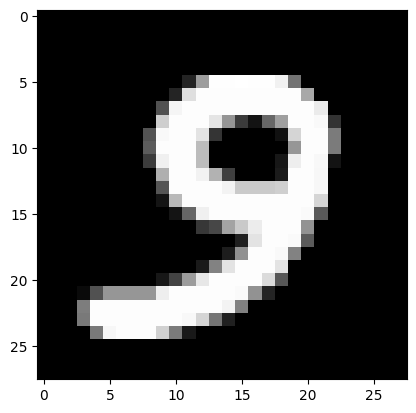

예측 : 8, 정답 : 2


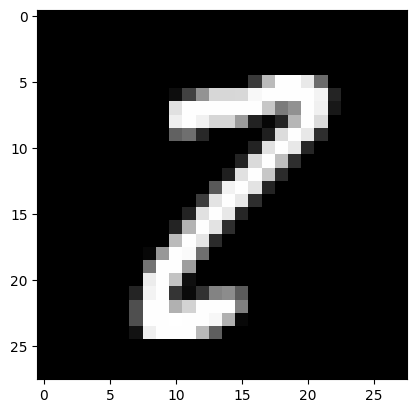

예측 : 6, 정답 : 1


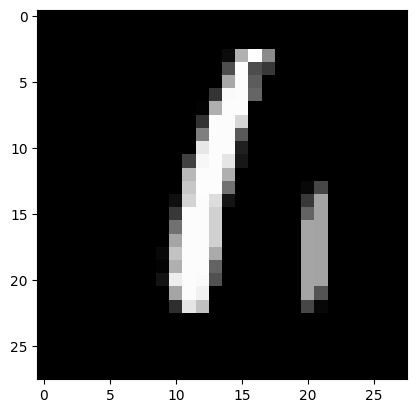

예측 : 0, 정답 : 8


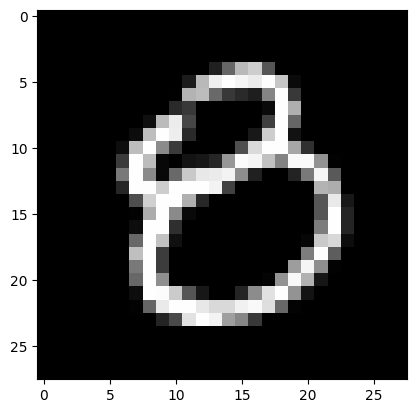

예측 : 9, 정답 : 3


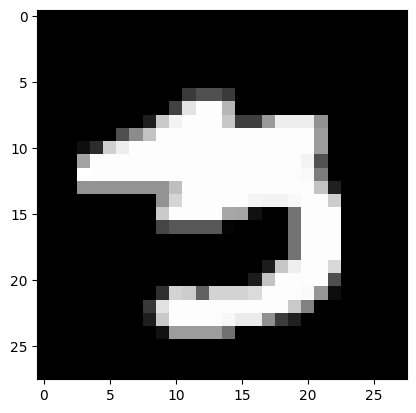

예측 : 4, 정답 : 2


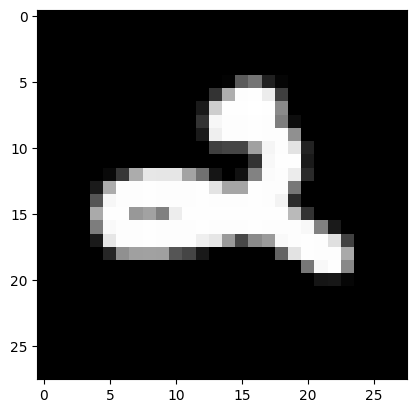

예측 : 4, 정답 : 8


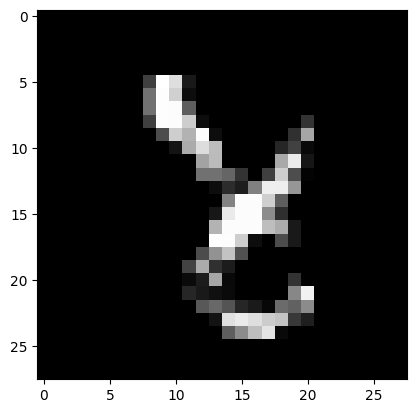

예측 : 2, 정답 : 7


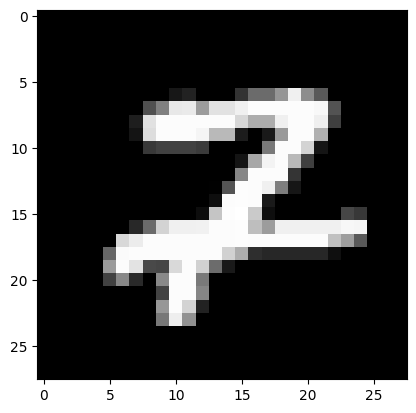

예측 : 5, 정답 : 3


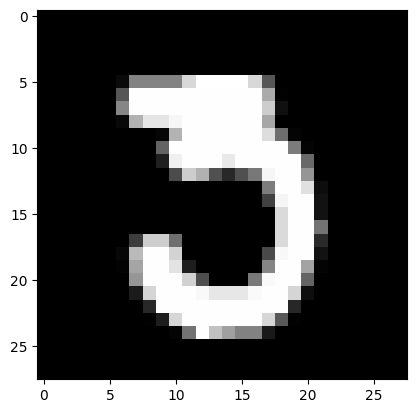

예측 : 9, 정답 : 8


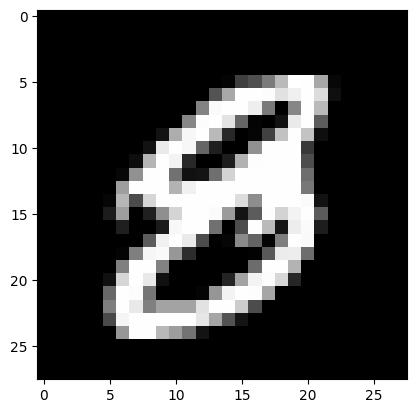

예측 : 0, 정답 : 6


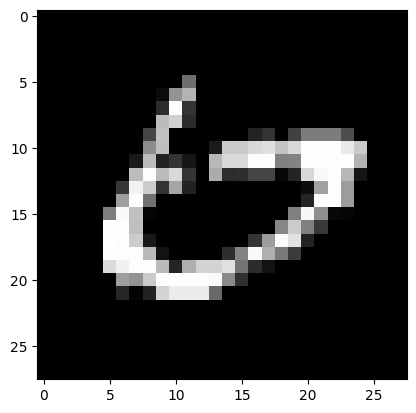

예측 : 2, 정답 : 0


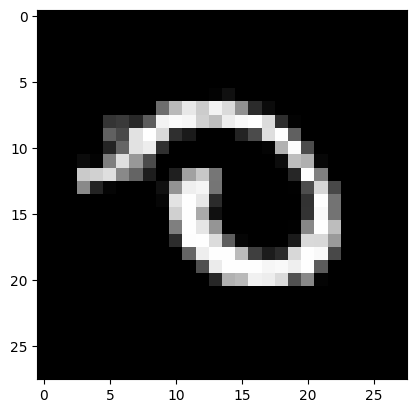

예측 : 8, 정답 : 7


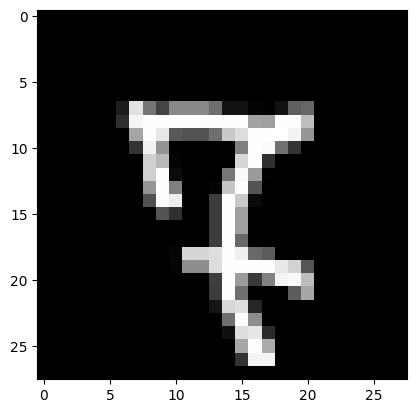

예측 : 0, 정답 : 2


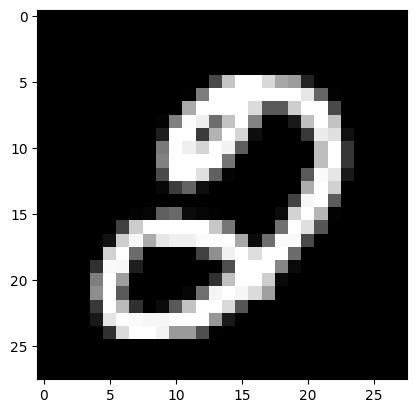

예측 : 3, 정답 : 2


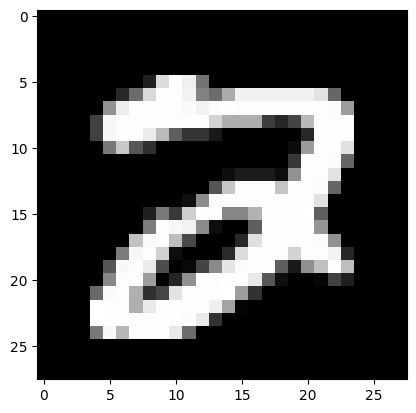

예측 : 0, 정답 : 8


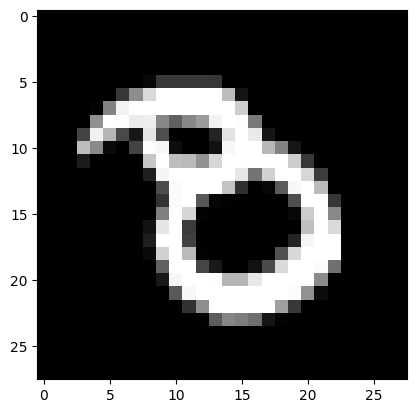

예측 : 2, 정답 : 1


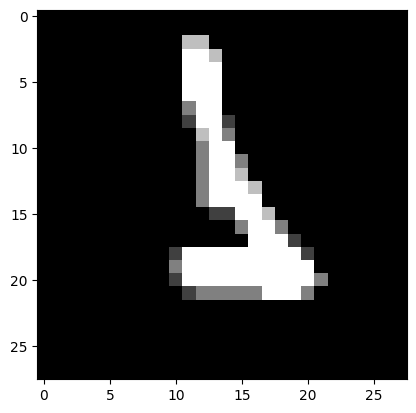

예측 : 5, 정답 : 8


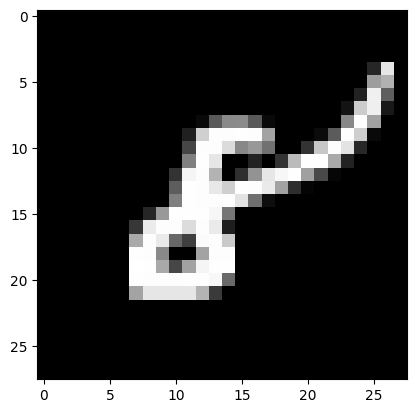

예측 : 3, 정답 : 2


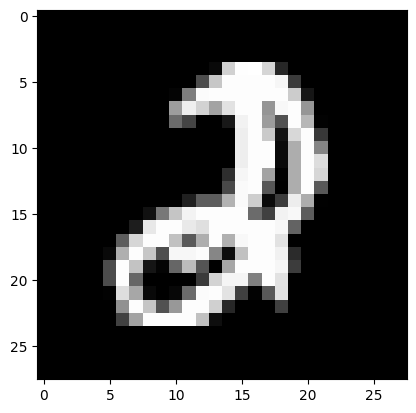

예측 : 9, 정답 : 8


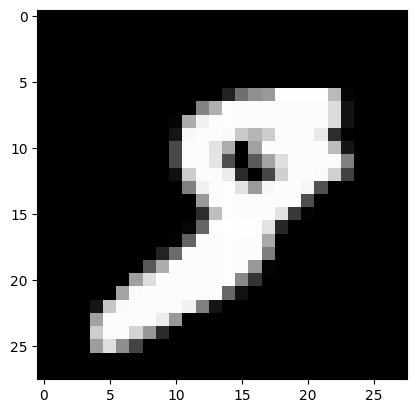

예측 : 9, 정답 : 2


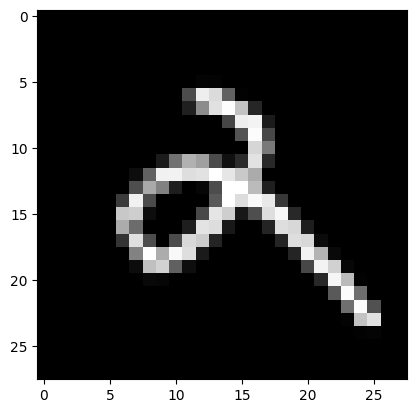

예측 : 0, 정답 : 8


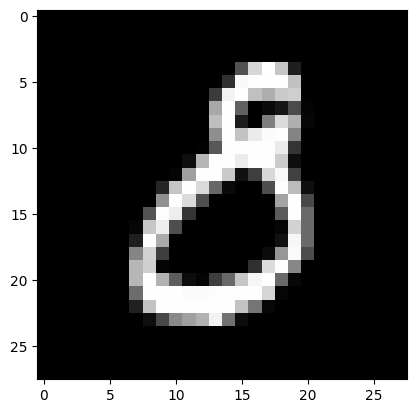

예측 : 3, 정답 : 1


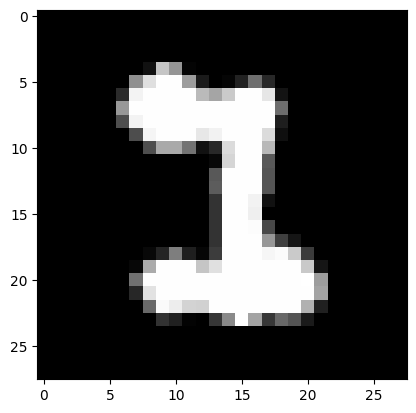

예측 : 4, 정답 : 7


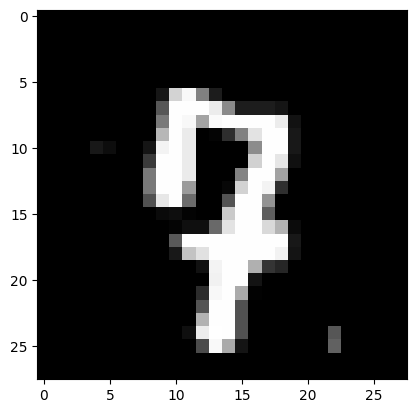

예측 : 2, 정답 : 8


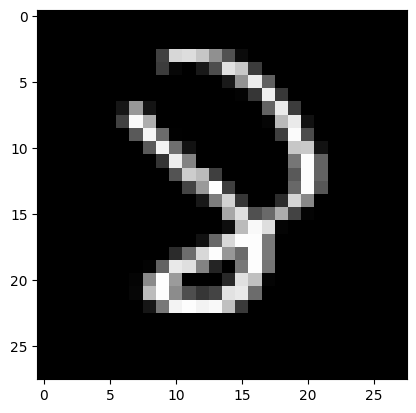

예측 : 3, 정답 : 9


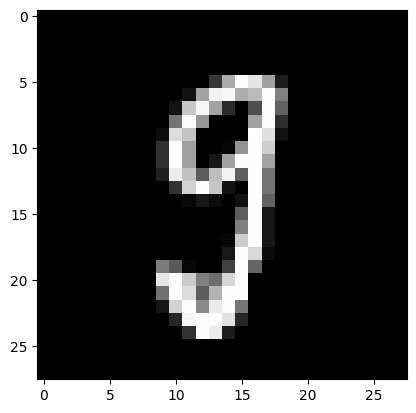

예측 : 5, 정답 : 9


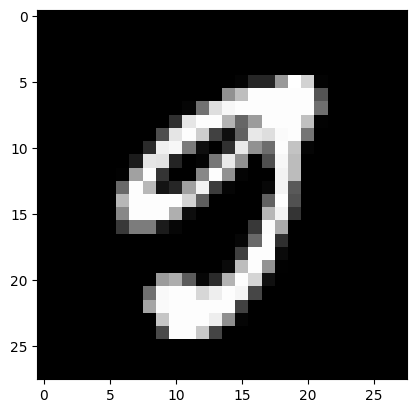

예측 : 7, 정답 : 2


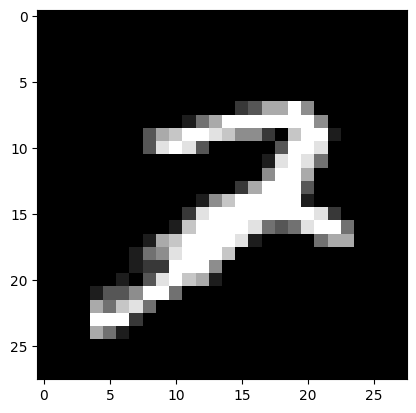

예측 : 6, 정답 : 5


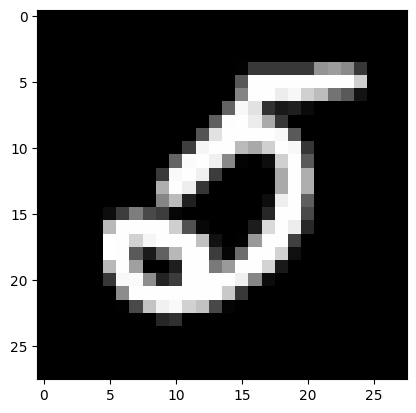

예측 : 5, 정답 : 9


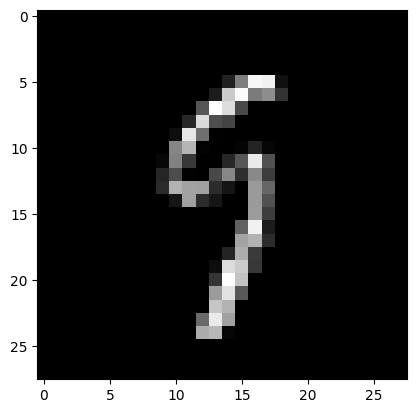

예측 : 6, 정답 : 5


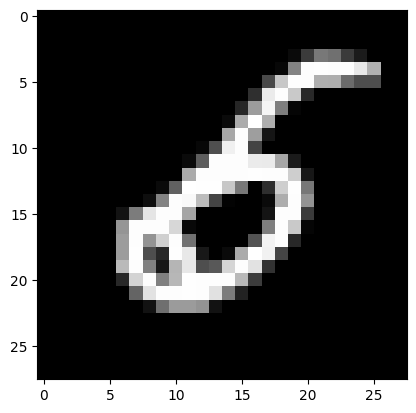

예측 : 4, 정답 : 8


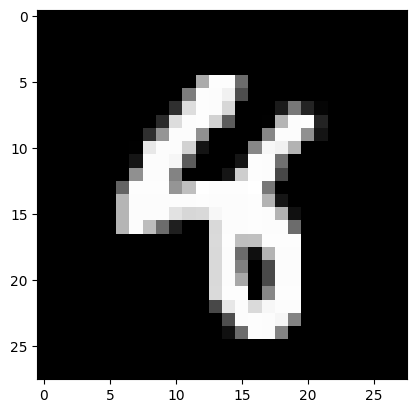

예측 : 2, 정답 : 7


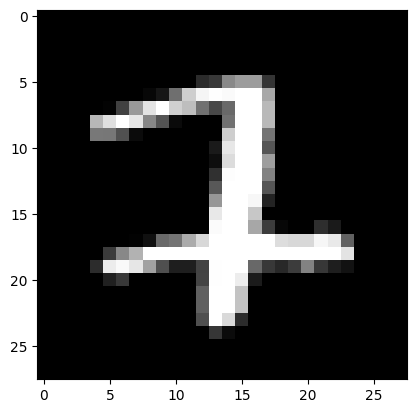

예측 : 8, 정답 : 3


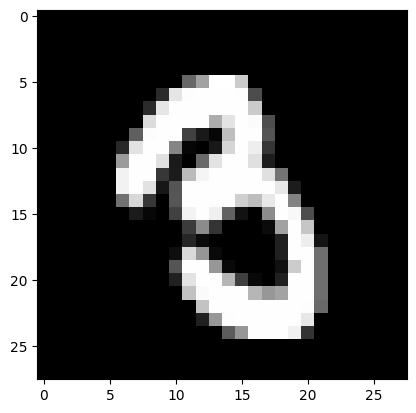

예측 : 8, 정답 : 2


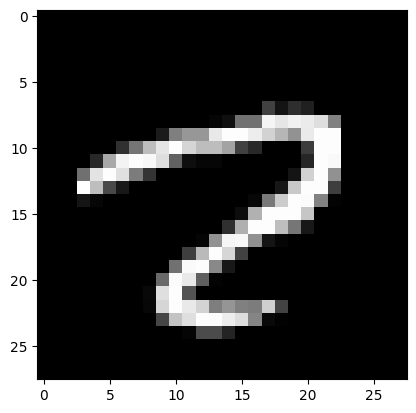

예측 : 9, 정답 : 4


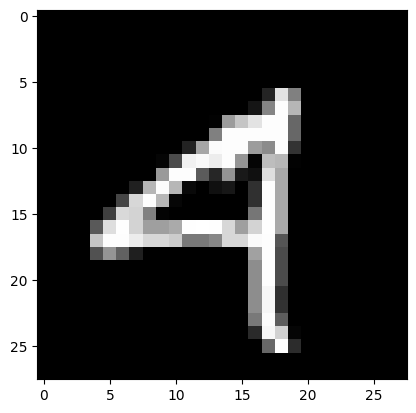

예측 : 8, 정답 : 0


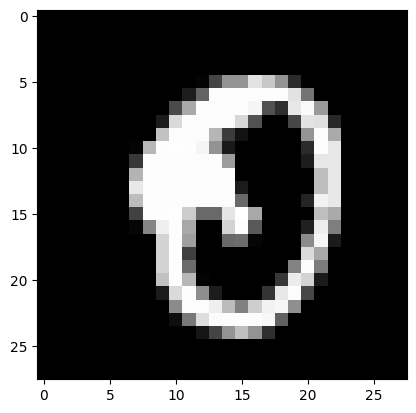

예측 : 7, 정답 : 3


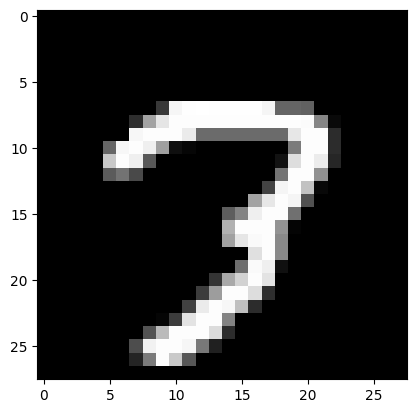

예측 : 0, 정답 : 8


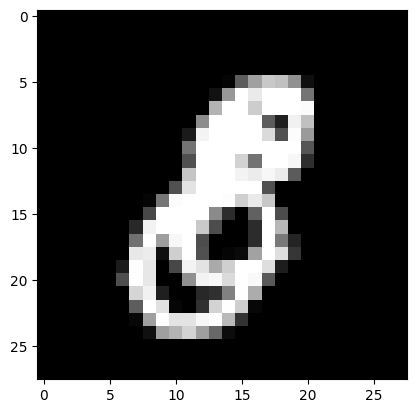

예측 : 0, 정답 : 8


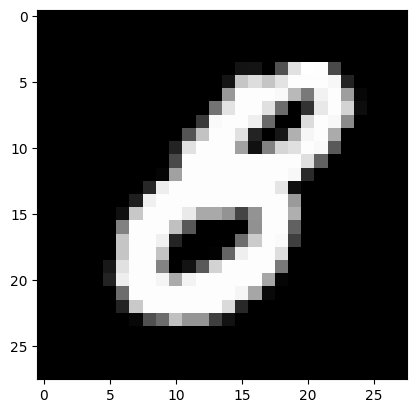

예측 : 4, 정답 : 6


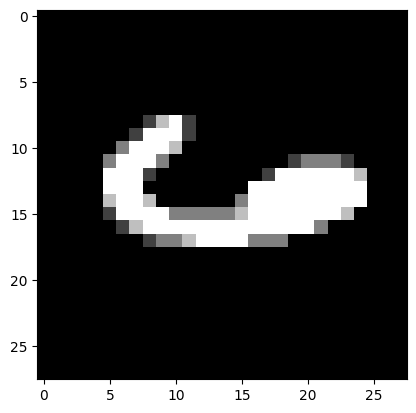

예측 : 4, 정답 : 8


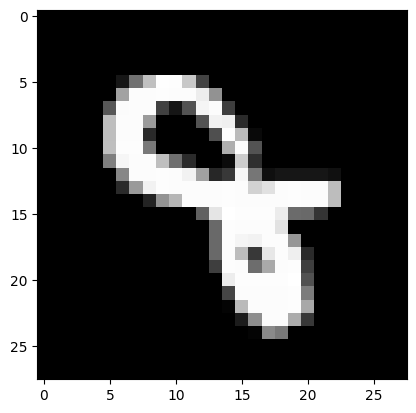

예측 : 8, 정답 : 7


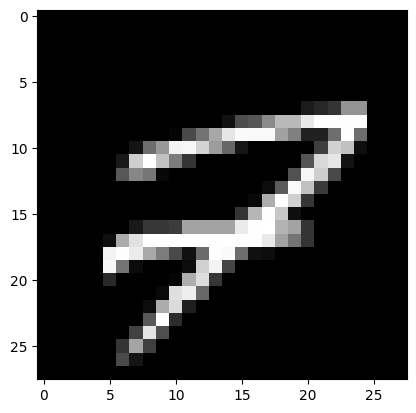

예측 : 2, 정답 : 6


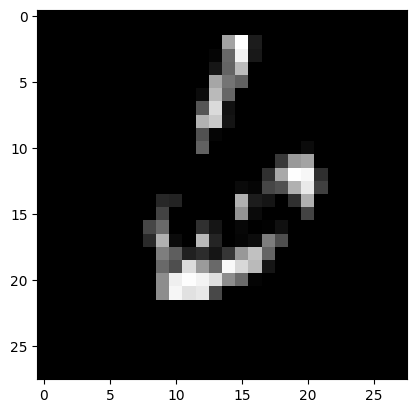

예측 : 3, 정답 : 2


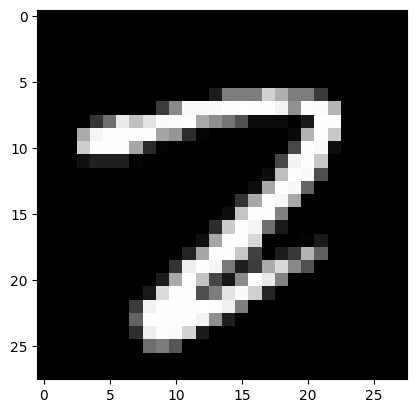

예측 : 8, 정답 : 2


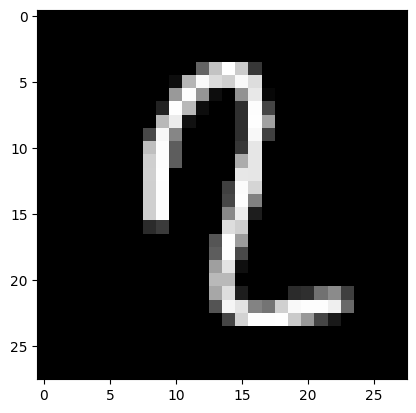

예측 : 8, 정답 : 2


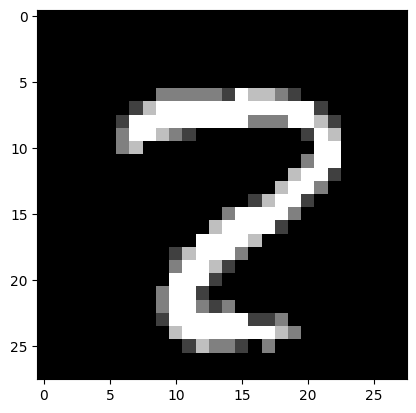

예측 : 9, 정답 : 4


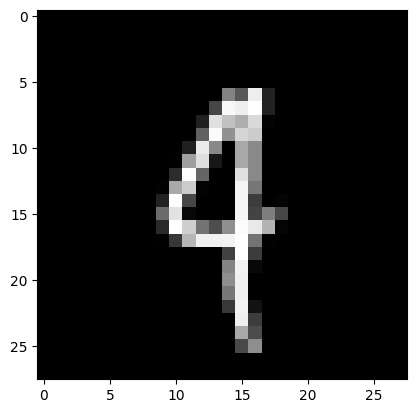

예측 : 0, 정답 : 6


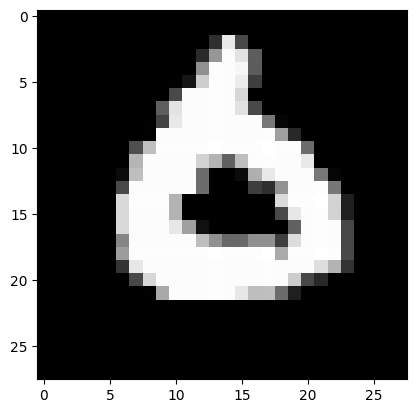

예측 : 3, 정답 : 5


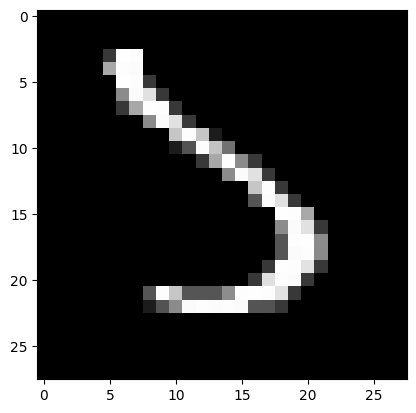

예측 : 2, 정답 : 3


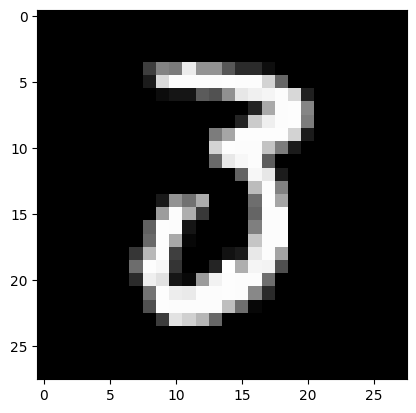

예측 : 1, 정답 : 2


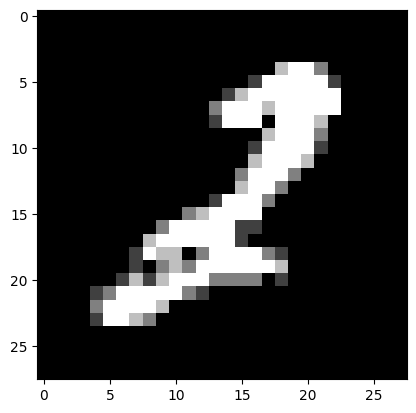

예측 : 6, 정답 : 8


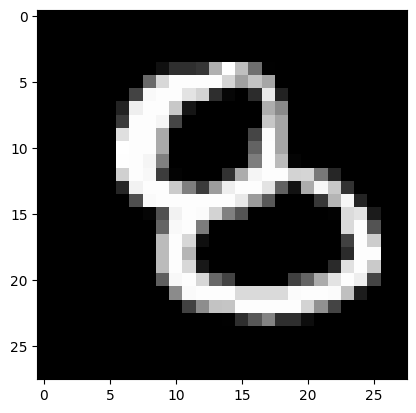

예측 : 0, 정답 : 6


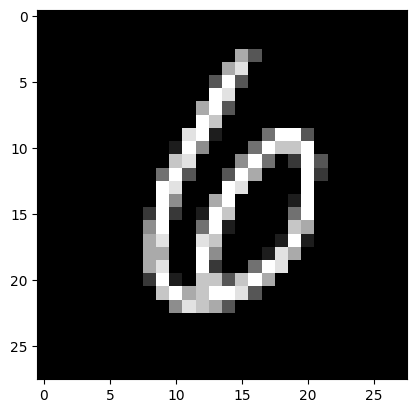

예측 : 4, 정답 : 2


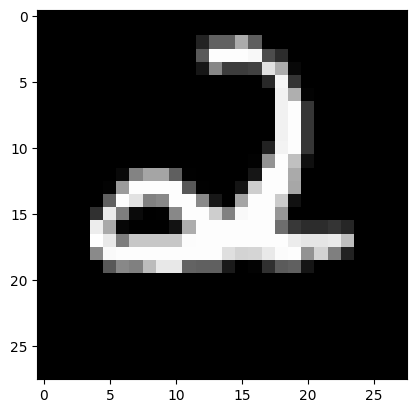

예측 : 1, 정답 : 8


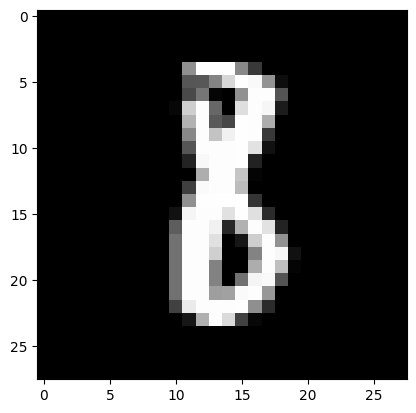

예측 : 1, 정답 : 8


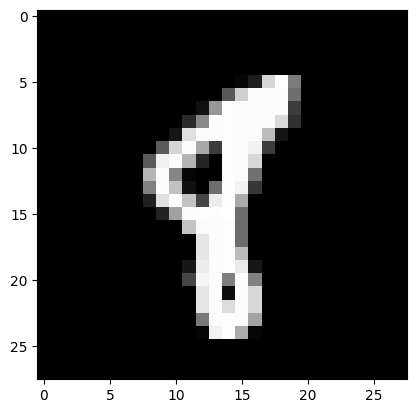

예측 : 5, 정답 : 8


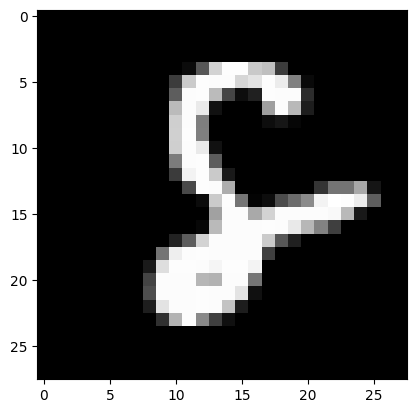

예측 : 1, 정답 : 7


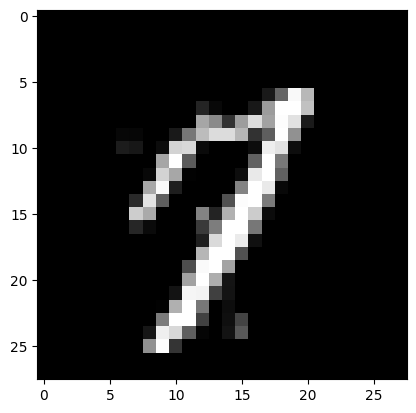

예측 : 6, 정답 : 8


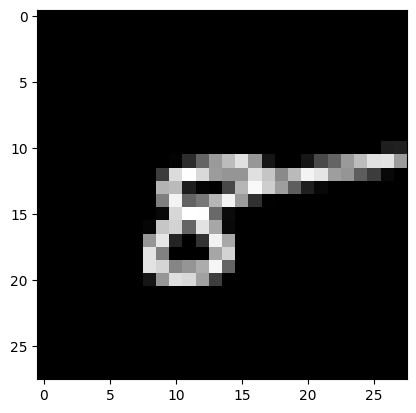

예측 : 8, 정답 : 1


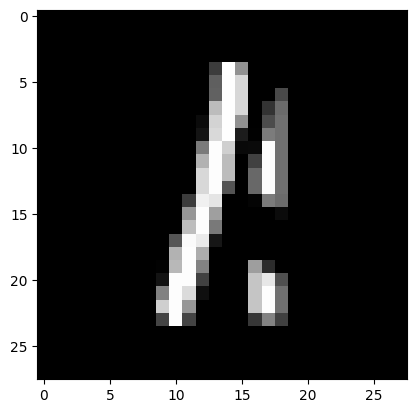

예측 : 1, 정답 : 7


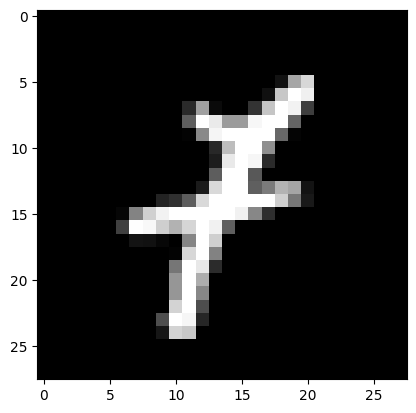

예측 : 0, 정답 : 8


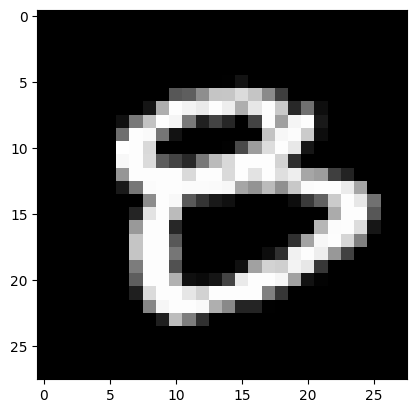

예측 : 7, 정답 : 5


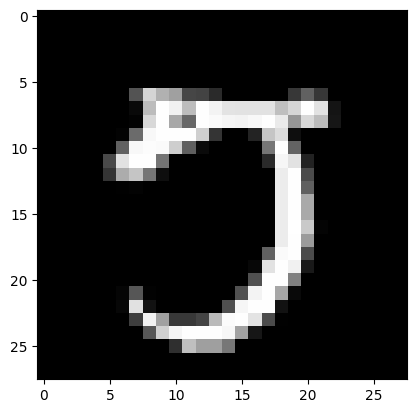

예측 : 0, 정답 : 8


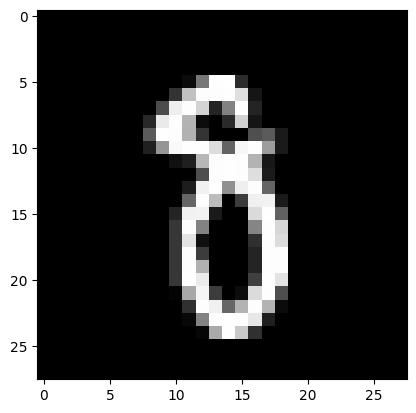

예측 : 7, 정답 : 9


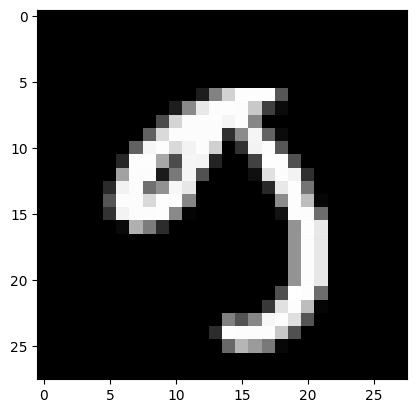

예측 : 5, 정답 : 8


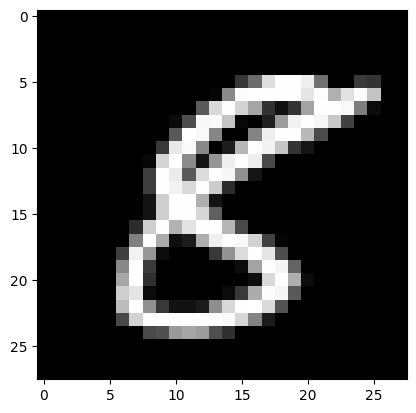

예측 : 9, 정답 : 4


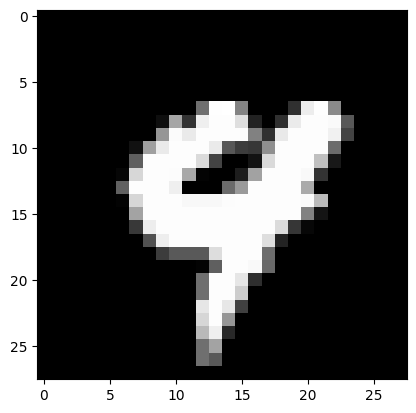

예측 : 1, 정답 : 2


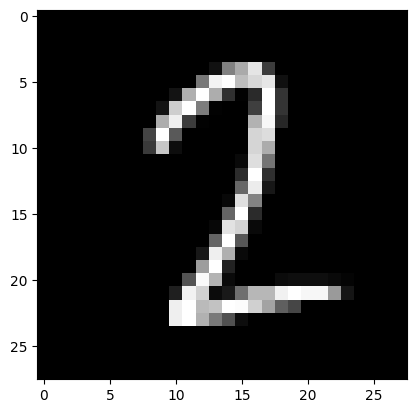

예측 : 7, 정답 : 9


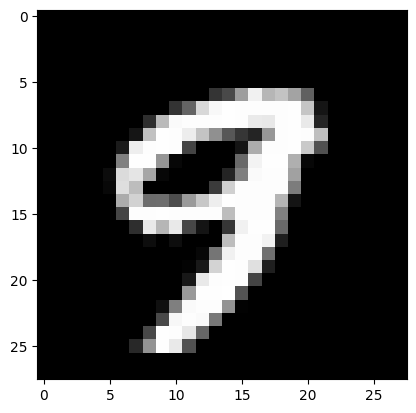

예측 : 9, 정답 : 7


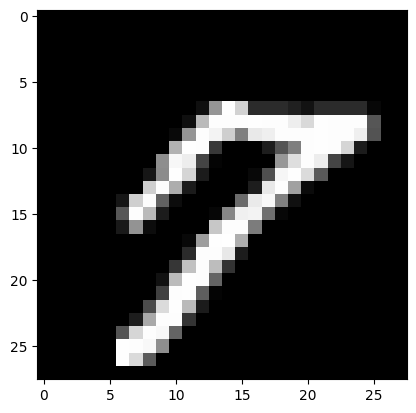

예측 : 9, 정답 : 3


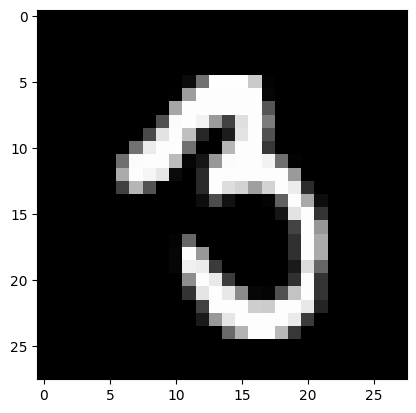

예측 : 0, 정답 : 8


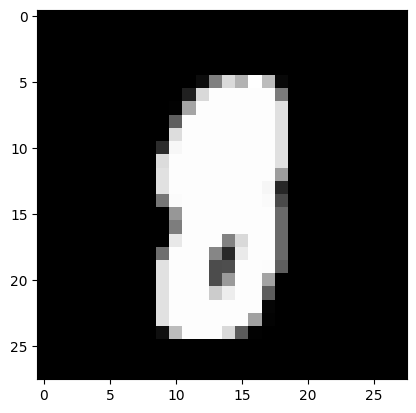

예측 : 9, 정답 : 7


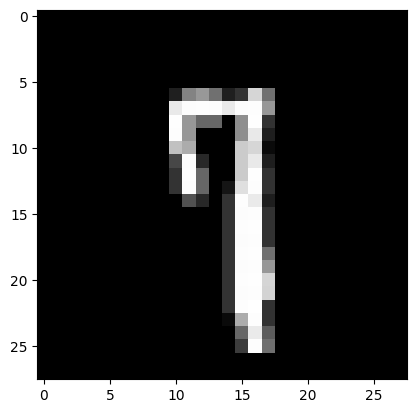

예측 : 8, 정답 : 7


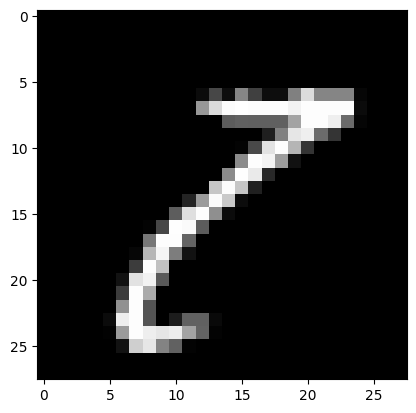

예측 : 1, 정답 : 7


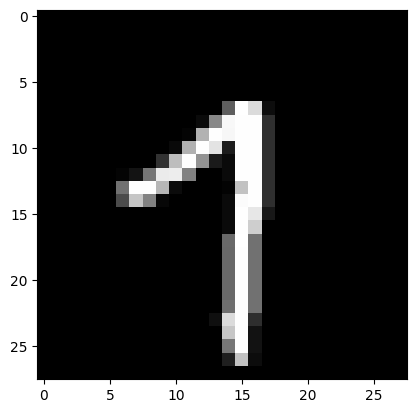

예측 : 2, 정답 : 7


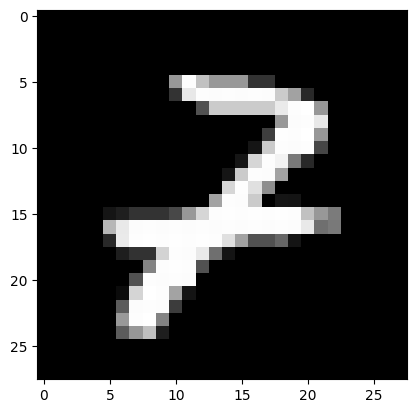

예측 : 6, 정답 : 5


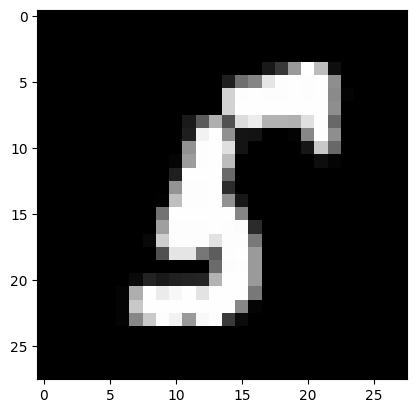

예측 : 0, 정답 : 4


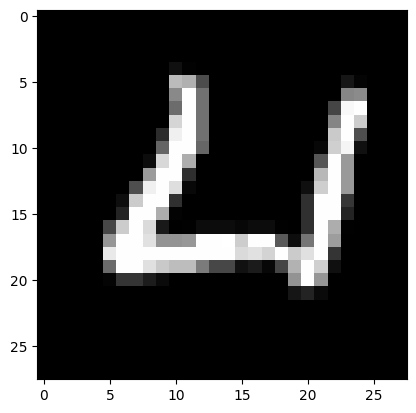

예측 : 0, 정답 : 8


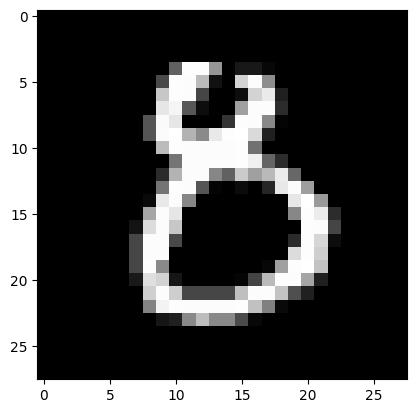

예측 : 4, 정답 : 9


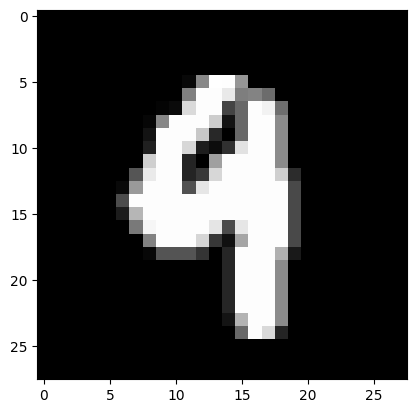

예측 : 0, 정답 : 8


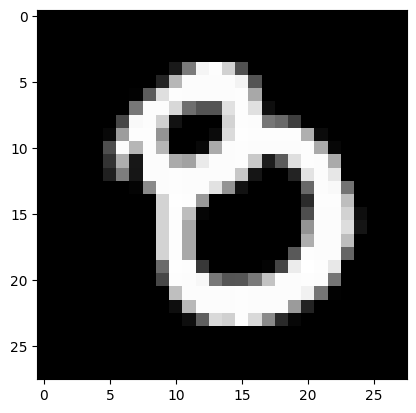

예측 : 0, 정답 : 3


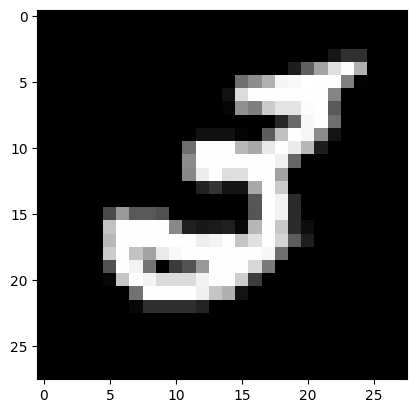

예측 : 9, 정답 : 3


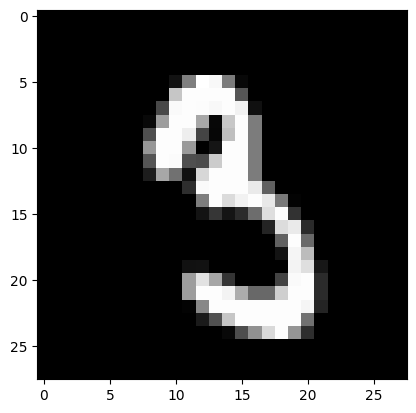

예측 : 8, 정답 : 2


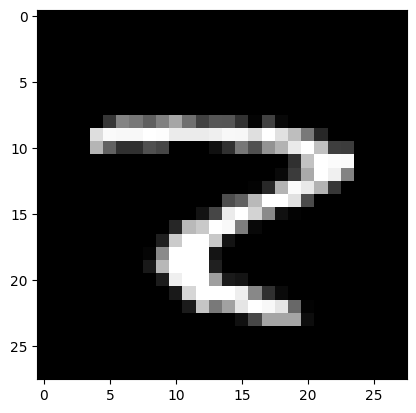

예측 : 7, 정답 : 8


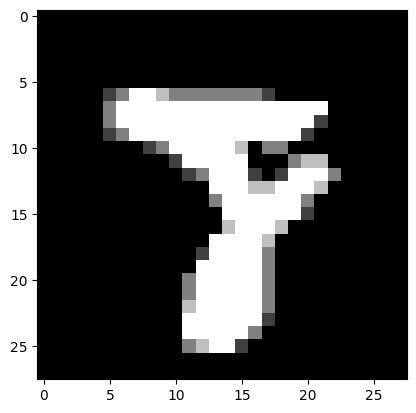

예측 : 9, 정답 : 7


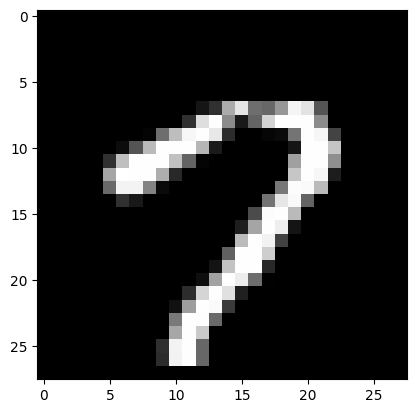

예측 : 3, 정답 : 2


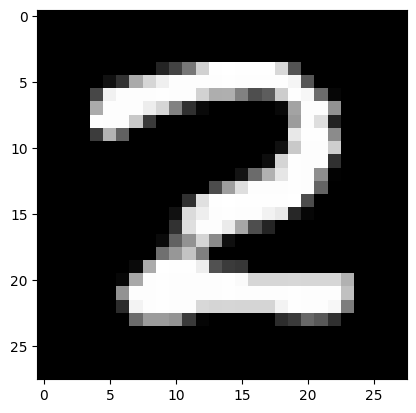

예측 : 1, 정답 : 4


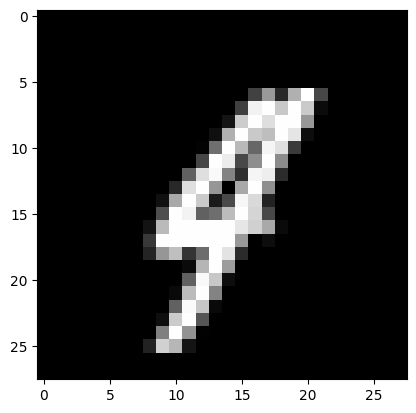

예측 : 3, 정답 : 9


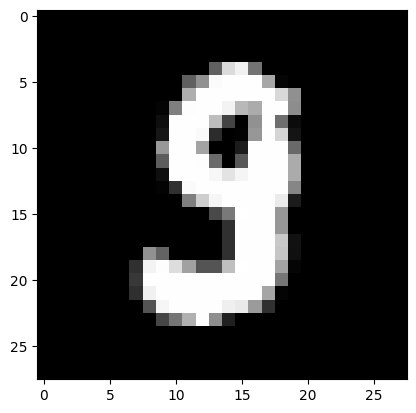

예측 : 7, 정답 : 0


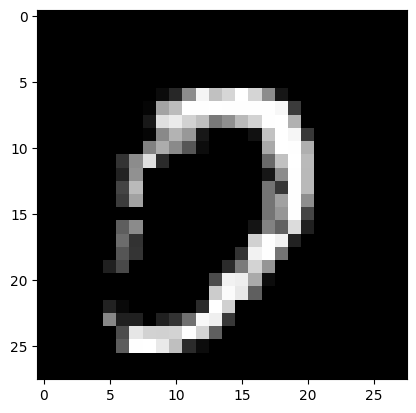

예측 : 2, 정답 : 3


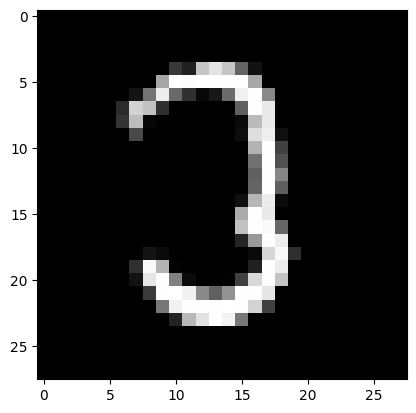

예측 : 9, 정답 : 4


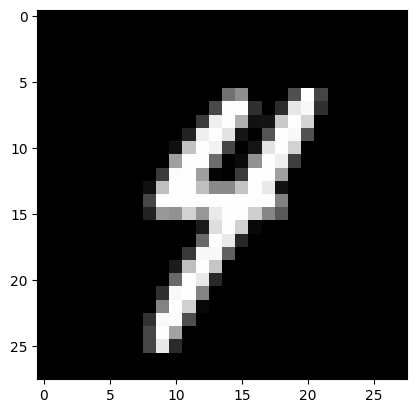

예측 : 0, 정답 : 8


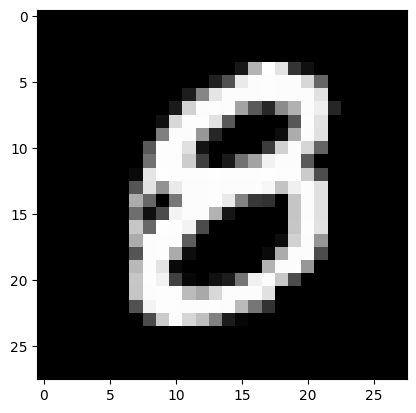

예측 : 9, 정답 : 3


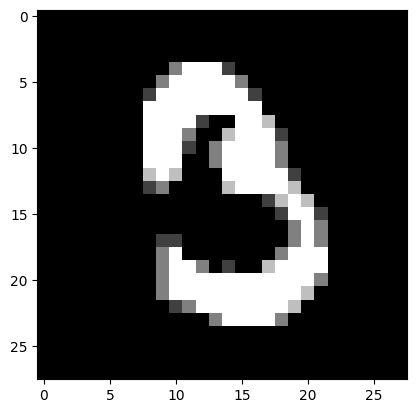

예측 : 6, 정답 : 2


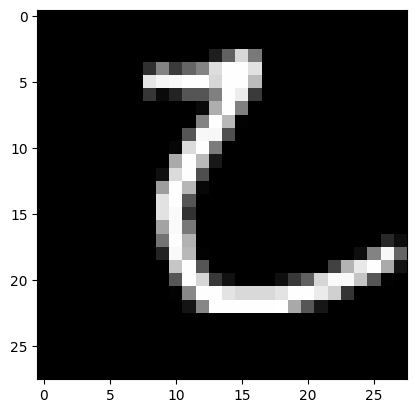

예측 : 4, 정답 : 9


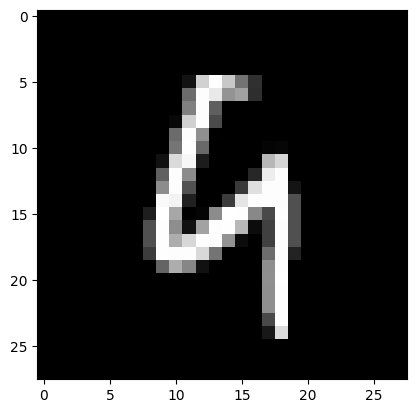

예측 : 3, 정답 : 2


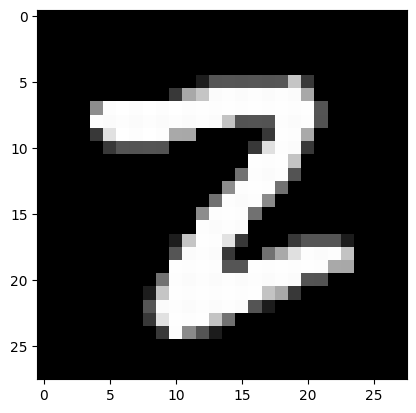

예측 : 9, 정답 : 7


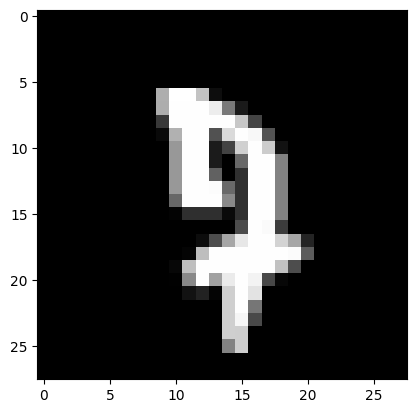

예측 : 7, 정답 : 3


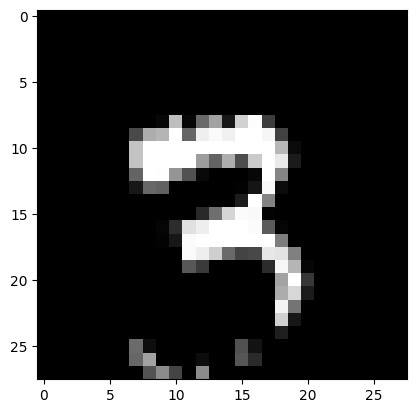

예측 : 3, 정답 : 6


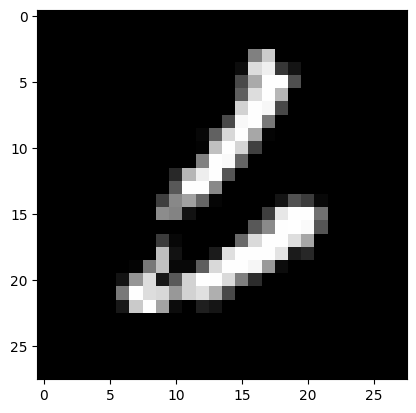

예측 : 6, 정답 : 4


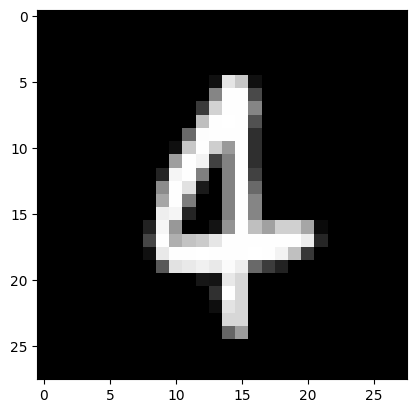

예측 : 0, 정답 : 8


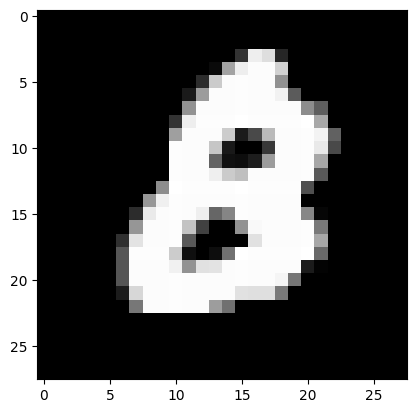

예측 : 4, 정답 : 9


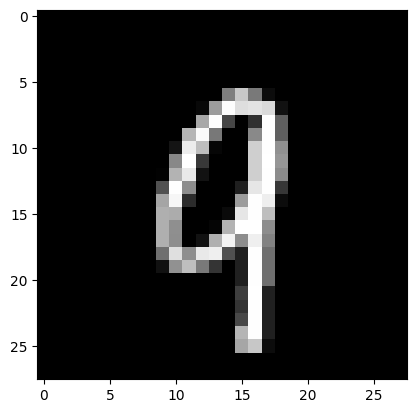

예측 : 2, 정답 : 7


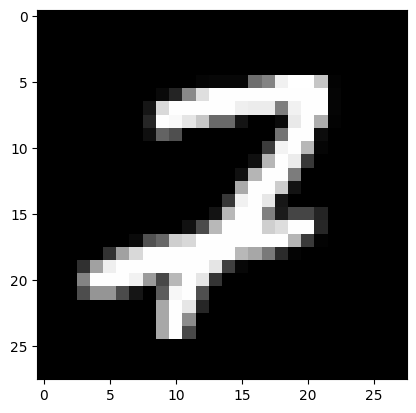

예측 : 9, 정답 : 4


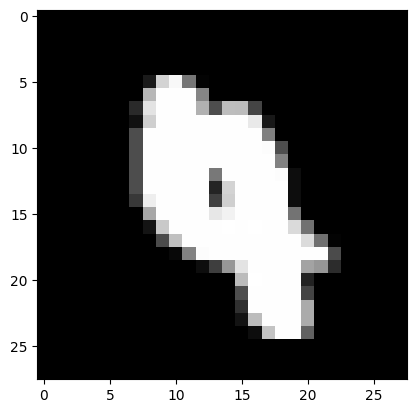

예측 : 3, 정답 : 9


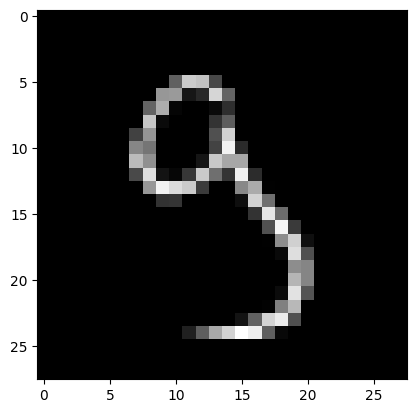

예측 : 5, 정답 : 3


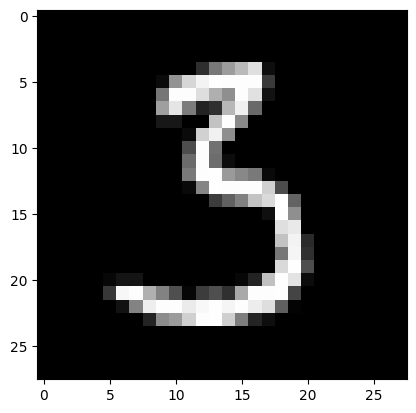

In [27]:
for falut in falut_data:
    print(f"예측 : {falut['pred']}, 정답 : {falut['label']}")
    plt.imshow(falut['image'].view(28, 28), cmap='gray')
    plt.show()

In [18]:
preds.data.shape

torch.Size([16, 10])

In [19]:
_, pred = torch.max(preds.data, dim = 1)
pred

tensor([4, 6, 7, 0, 5, 8, 2, 4, 6, 9, 3, 8, 6, 4, 0, 7], device='cuda:0')

In [20]:
pred == labels

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True], device='cuda:0')

In [21]:
(pred == labels).sum()

tensor(15, device='cuda:0')